In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports Libraries

In [4]:
!pip install pesq
!pip install pystoi


import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274949 sha256=a7ccae4439d7e4bfc7fba9156797e60d488ecb344c46ddd7911d8997dc09aaaa
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [5]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.7 MB/s eta 0:00:00


#Import Libraries

In [6]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

# Load Data and Preprocess

In [7]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [8]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

# Create and Run Model

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def calculate_snr(clean_signal, noisy_signal):
    """Calculates the Signal-to-Noise Ratio (SNR)."""
    # Ensure signals are NumPy arrays
    clean_signal = np.array(clean_signal)
    noisy_signal = np.array(noisy_signal)

    # Calculate the power of the clean signal
    clean_power = np.sum(clean_signal**2)

    # Calculate the power of the noise (noisy - clean)
    noise_power = np.sum((noisy_signal - clean_signal)**2)

    # Calculate SNR in dB
    snr = 10 * np.log10(clean_power / noise_power) if noise_power != 0 else float('inf') # handle division by zero

    return snr


def calculate_metrics(clean_signal, noisy_signal, enhanced_signal, sr=8000):
    """Calculates SNR, STOI, and PESQ metrics."""
    snr_noisy = calculate_snr(clean_signal, noisy_signal)
    snr_enhanced = calculate_snr(clean_signal, enhanced_signal)

    stoi_score = stoi(clean_signal, enhanced_signal, sr, extended=False)

    # Changed 'wb' to 'nb' for narrowband mode as sr=8000
    pesq_score = pesq(sr, clean_signal, enhanced_signal, 'nb')

    return snr_noisy, snr_enhanced, stoi_score, pesq_score


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    inputs_copy = tf.identity(inputs)
    x = inputs / tf.reduce_max(inputs)

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
    Layer,
    Lambda
)



def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


class NormalizeInputLayer(Layer):
    def __init__(self, **kwargs):
        super(NormalizeInputLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs / tf.reduce_max(inputs)




def custom_unet(

    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple


    inputs = Input(input_shape)


    class IdentityLayer(Layer):
        def call(self, inputs):
            return tf.identity(inputs)

    inputs_copy = IdentityLayer()(inputs)
    down_layers = []


    x = NormalizeInputLayer()(inputs)


    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16,
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = 'model_weights.weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1)

model.compile(optimizer='adam', loss=signal_enhancement_loss)

# Run Model
(Commented out as I am reading in a previously run model)

In [13]:
 history = model.fit(train_dataset,epochs=300,shuffle=True, validation_data=val_dataset,
                     callbacks=[callback_checkpoint, callback_early_stop])

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, None, 128, 1))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1068
Epoch 1: val_loss improved from inf to 0.46480, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - loss: 0.1062 - val_loss: 0.4648
Epoch 2/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0730
Epoch 2: val_loss improved from 0.46480 to 0.27729, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - loss: 0.0727 - val_loss: 0.2773
Epoch 3/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0739
Epoch 3: val_loss improved from 0.27729 to 0.22693, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - loss: 0.0735 - val_loss: 0.2269
Epoch 4/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0657
Epoch 4: val_loss did not improve from 0.22693
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.0654 - val_loss: 0.2513
Epoch 5/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0664
Epoch 5: val_loss improved from 0.22693 to 0.21196, saving model to m

# Inspect Results

In [14]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))




In [15]:
for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    # Convert tensors to NumPy arrays and squeeze to 1D
    # Changed 'wb' to 'nb' for narrowband mode as sr=8000
    pesq_with_noise[ind] = pesq(sr, clean_wav.numpy().squeeze(), corr_wav.numpy().squeeze(), 'nb')
    pesq_denoised[ind] = pesq(sr, clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), 'nb')

    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

'1.72, 2.26'

In [16]:
os.system('rm -r val_results')

256

In [17]:
results_dir = 'val_results'
os.mkdir(results_dir)

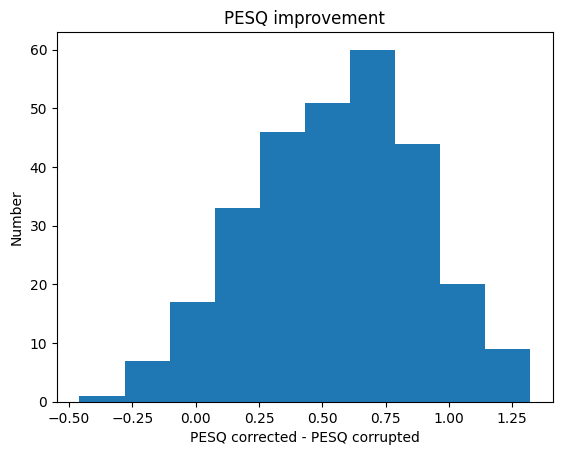

In [18]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

In [19]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [20]:
Audio(wav_clean_array[ind],rate=sr)

In [21]:
Audio(wav_corrupt_array[ind],rate=sr)

In [22]:
Audio(wav_correct_array[ind],rate=sr)

In [23]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)

In [24]:
Audio(wav_clean_array[ind],rate=sr)

In [25]:
Audio(wav_corrupt_array[ind],rate=sr)

In [26]:
Audio(wav_correct_array[ind],rate=sr)

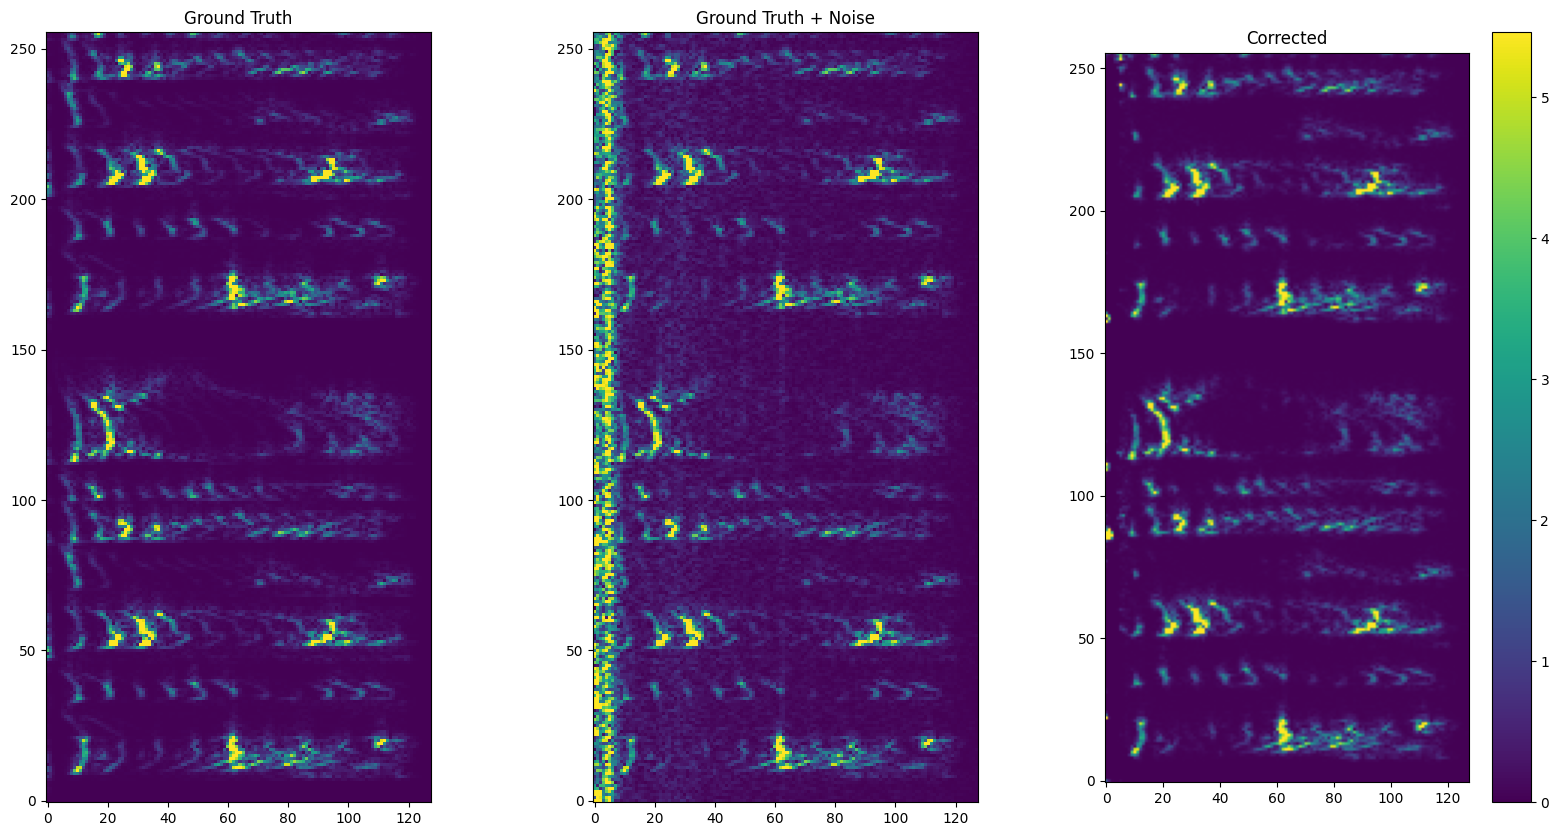

In [27]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

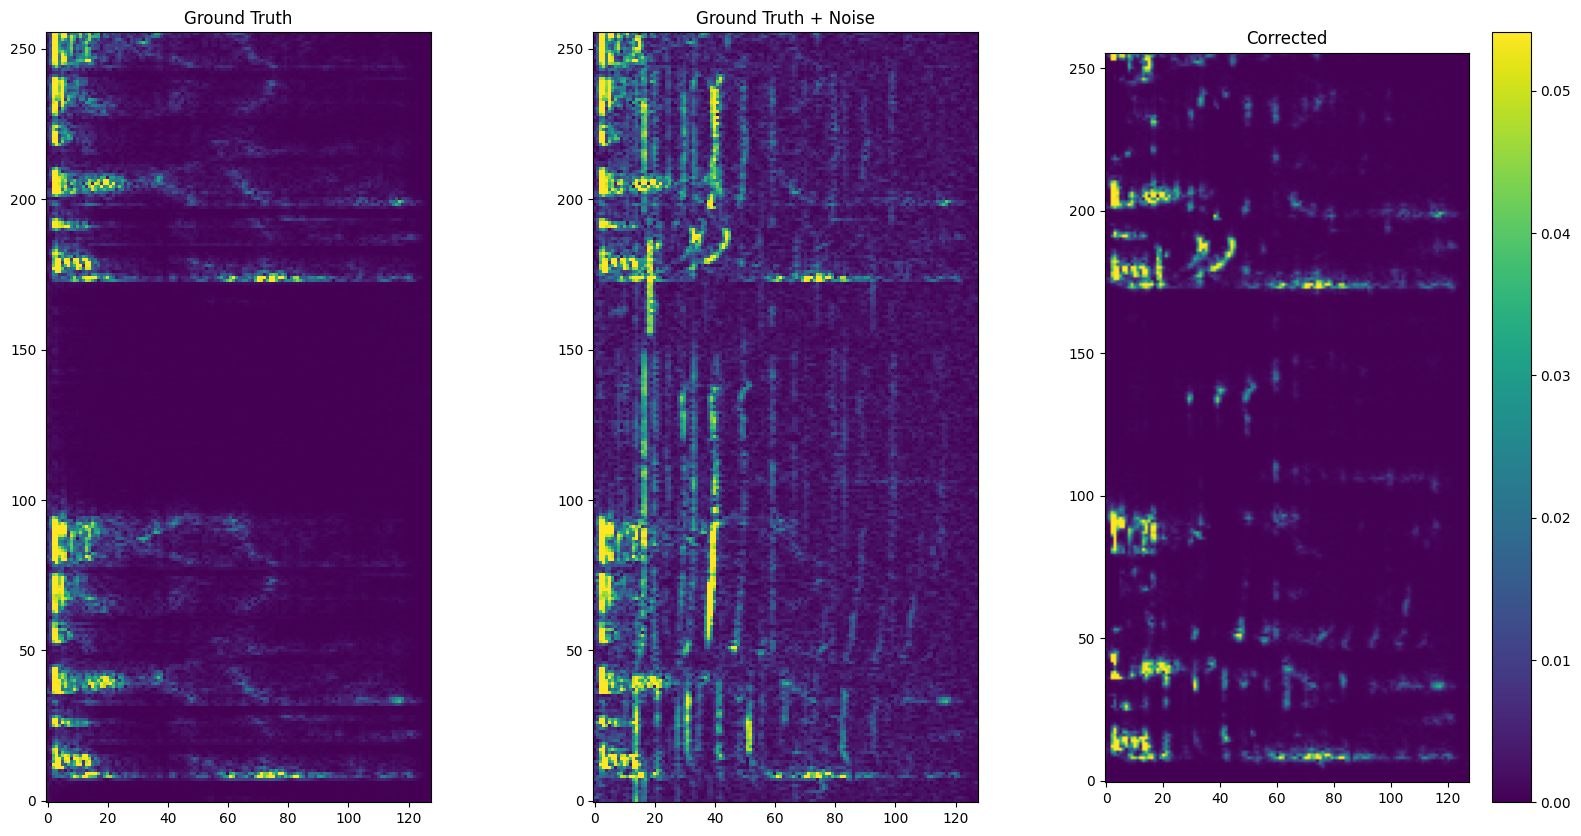

In [28]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

In [29]:
test_ = np.expand_dims(corr_amp,0)

In [30]:
%%timeit -n 50
test = model.predict(test_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [31]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

0

In [32]:
# After processing your audio:
clean_wav = wav_clean_array[ind] # Use actual clean audio data
wav_corrupt = wav_corrupt_array[ind]# Use actual corrupted audio data
wav_correct = wav_correct_array[ind] # Use actual corrected audio data
sr = 8000  # your sample rate

# Calculate and print the metrics:
# Assuming calculate_metrics is defined elsewhere
snr_noisy, snr_enhanced, stoi_score, pesq_score = calculate_metrics(clean_wav, wav_corrupt, wav_correct, sr)

print(f"SNR (Noisy): {snr_noisy:.2f} dB")
print(f"SNR (Enhanced): {snr_enhanced:.2f} dB")
print(f"STOI: {stoi_score:.2f}")
print(f"PESQ: {pesq_score:.2f}")






SNR (Noisy): 0.72 dB
SNR (Enhanced): 3.09 dB
STOI: 0.64
PESQ: 1.27


Evaluating for SNR: -5 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

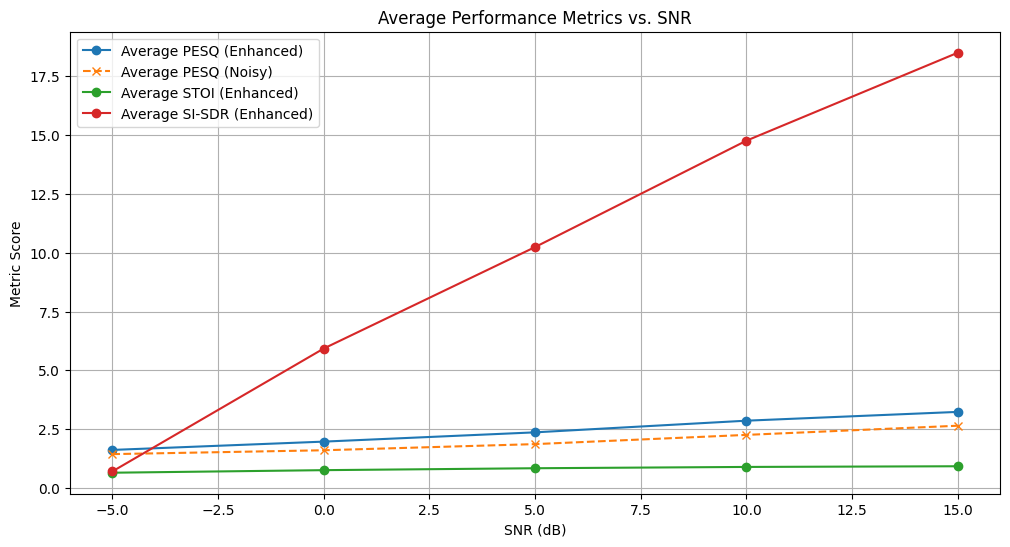

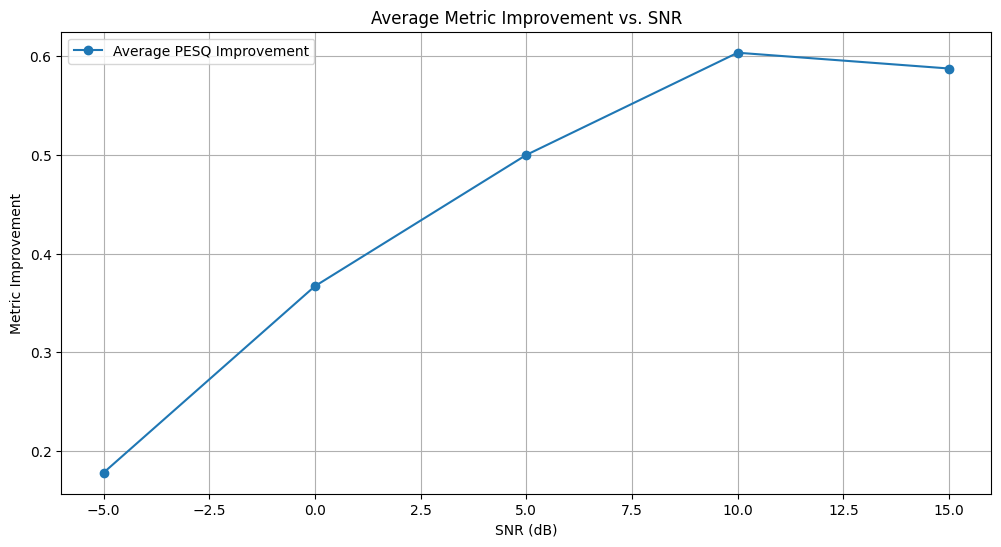


Example for SNR: -5 dB
Example audio files for SNR -5 dB saved to evaluation_results/audio_examples


<ipython-input-33-aab5489aaf77>:339: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


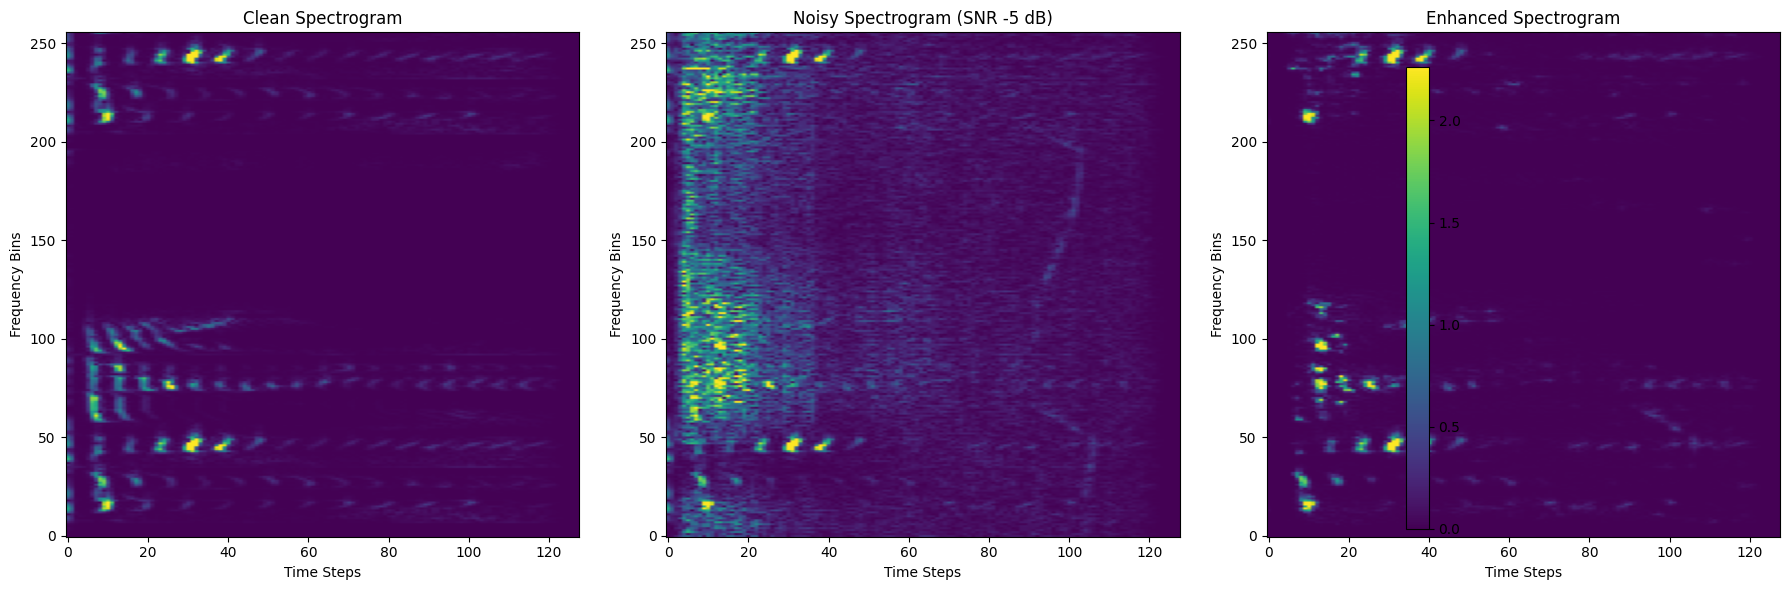


Example for SNR: 0 dB
Example audio files for SNR 0 dB saved to evaluation_results/audio_examples


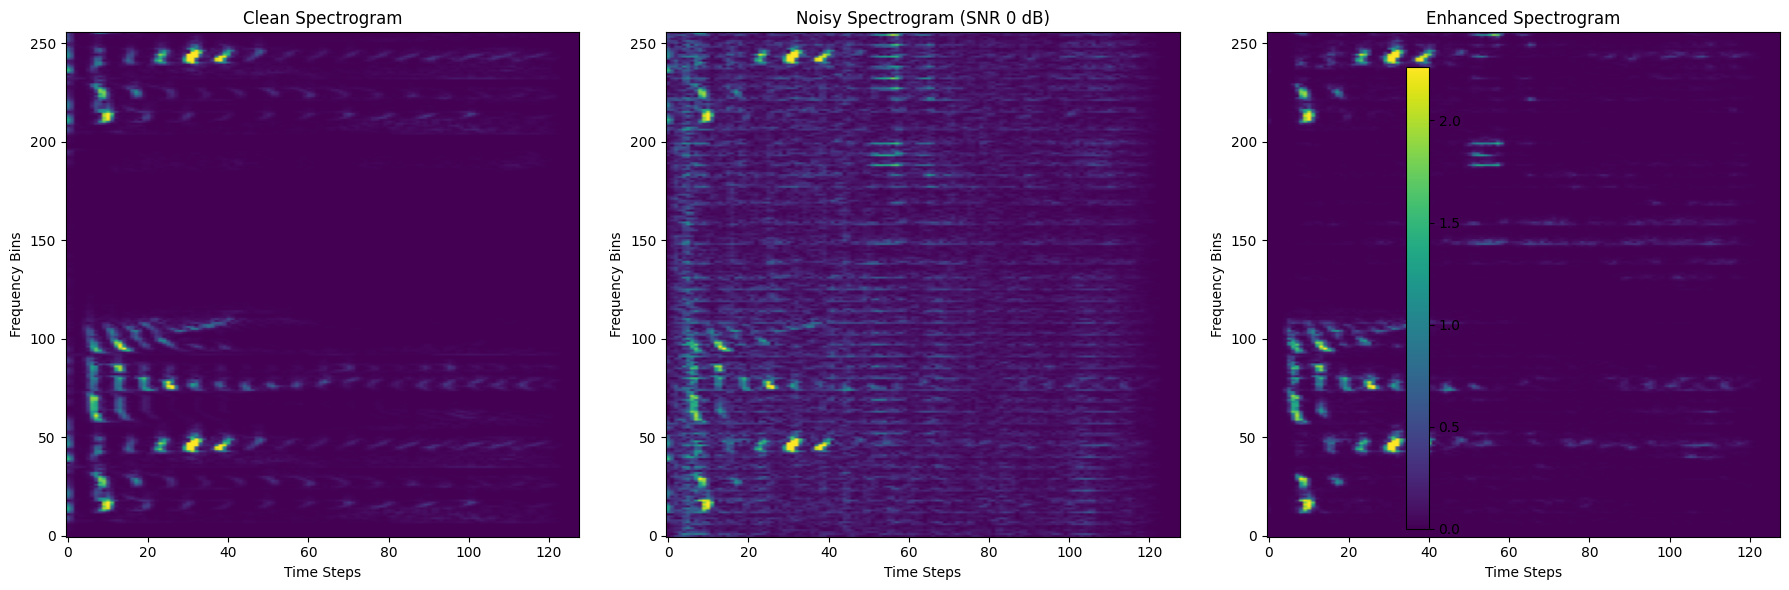


Example for SNR: 5 dB
Example audio files for SNR 5 dB saved to evaluation_results/audio_examples


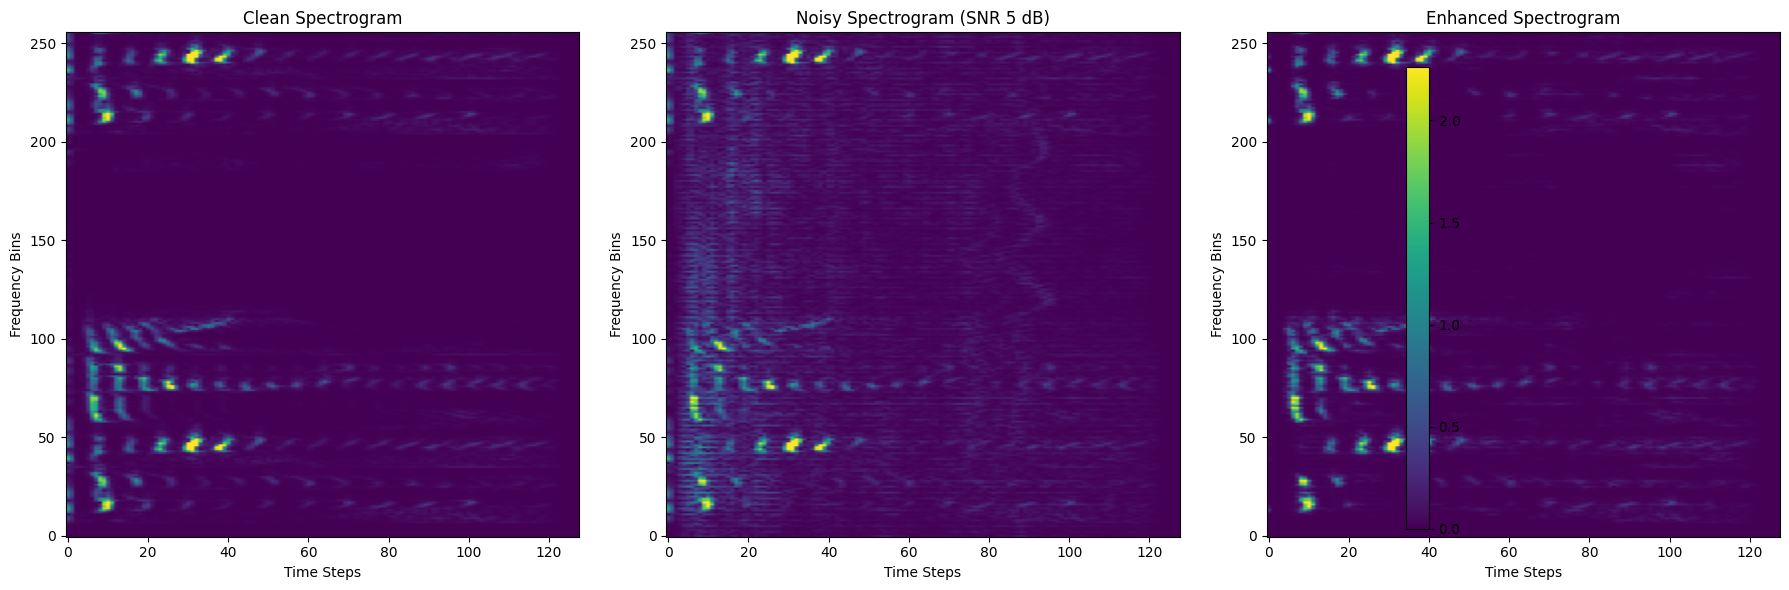


Example for SNR: 10 dB
Example audio files for SNR 10 dB saved to evaluation_results/audio_examples


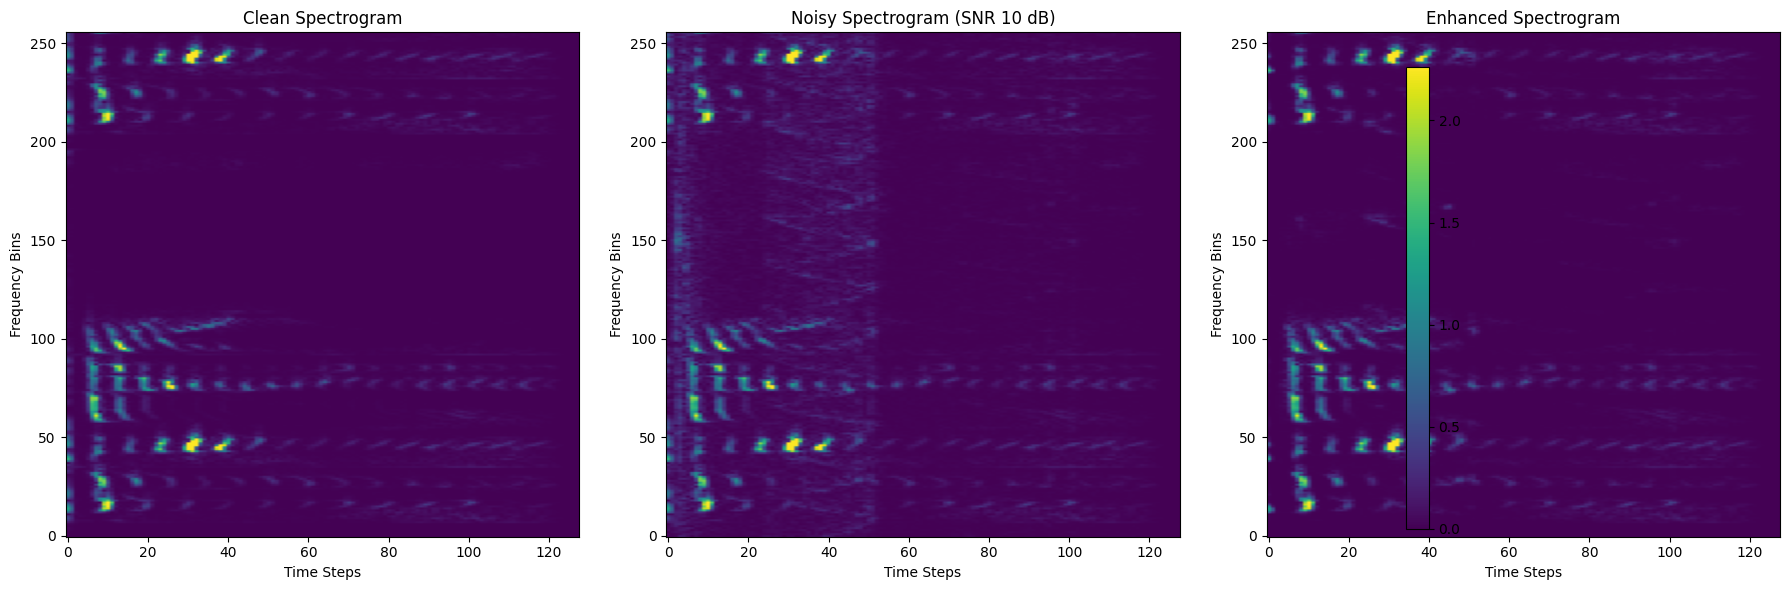


Example for SNR: 15 dB
Example audio files for SNR 15 dB saved to evaluation_results/audio_examples


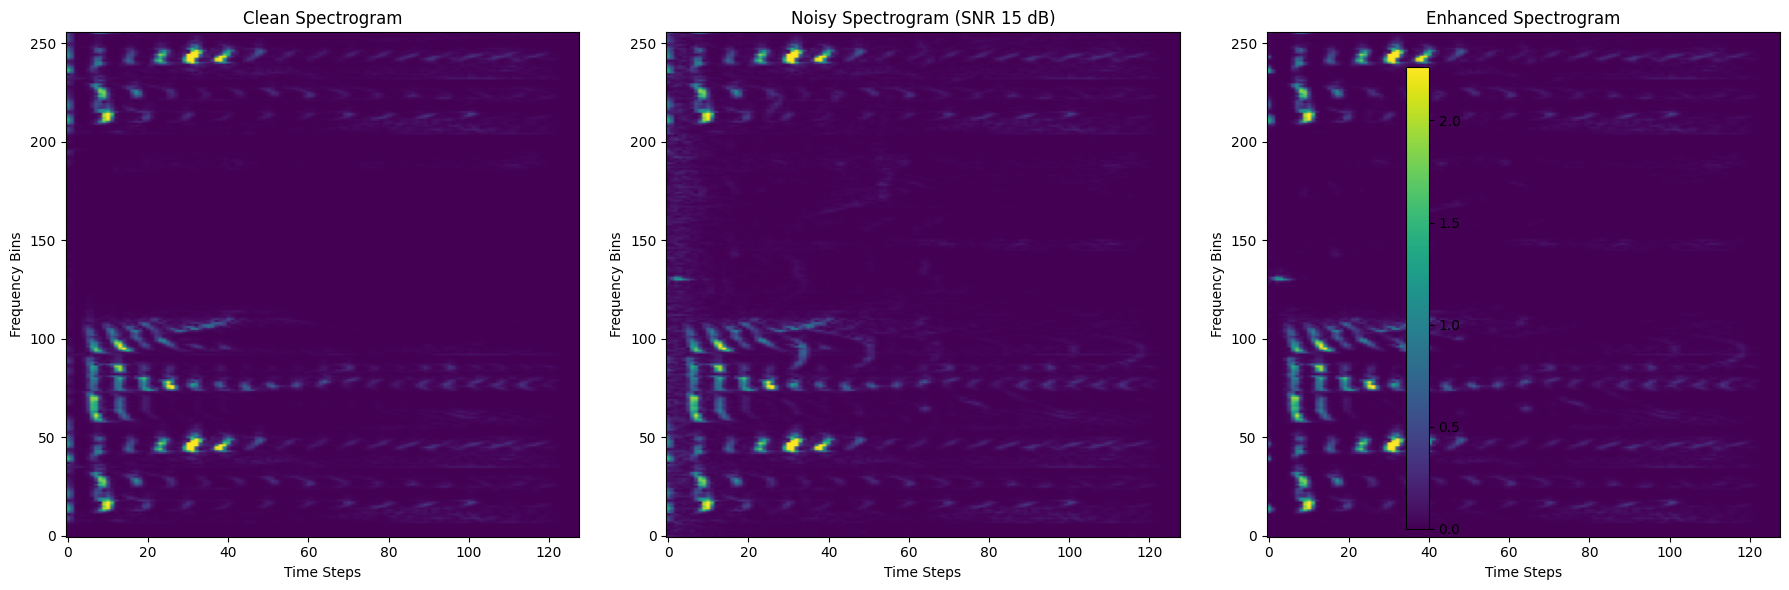

In [33]:
# Add these imports at the beginning of the file if not already present
import tensorflow as tf
import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq
import soundfile as sf
import os
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for saving results to CSV



# Function to calculate SI-SDR
def calculate_si_sdr(clean, estimate):
    """Calculates Scale-Invariant Source-to-Distortion Ratio (SI-SDR)."""
    # Ensure inputs are numpy arrays
    clean = np.array(clean)
    estimate = np.array(estimate)

    # Ensure same length (assuming padding/trimming is done elsewhere)
    min_len = min(len(clean), len(estimate))
    clean = clean[:min_len]
    estimate = estimate[:min_len]

    # Calculate projection of estimate onto clean
    s_target = np.sum(estimate * clean) * clean / np.sum(clean ** 2) if np.sum(clean ** 2) != 0 else clean * 0

    # Calculate error
    e_noise = estimate - s_target

    # Calculate SI-SDR
    # Handle potential division by zero by adding a small epsilon to the denominator
    epsilon = 1e-10
    # Use tf.reduce_sum for compatibility if inputs were tensors before conversion
    si_sdr = 10 * np.log10(np.sum(s_target ** 2) / (np.sum(e_noise ** 2) + epsilon))

    return si_sdr


@tf.function
def add_white_noise_with_snr(data, snr_db, sr=8000):
    """Adds white noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(data ** 2)

    if tf.equal(signal_power, 0.0):
        return data, data # Avoid division by zero if signal is silent

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise
    noise = tf.random.normal(shape=tf.shape(data), stddev=tf.sqrt(tf.cast(noise_power, tf.float32)))

    # Add noise to the signal
    noisy_data = data + noise

    return noisy_data, data

@tf.function
def add_urban_noise_with_snr(corr_data, data, snr_db, sr=sr):
    """Adds urban noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(corr_data ** 2)

    if tf.equal(signal_power, 0.0):
        return corr_data, data # Avoid division by zero

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Select a random urban noise file
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)

    # Trim or pad noise file to match the length of the data
    noisefile = noisefile[:tf.shape(corr_data)[0]]
    zero_padding = tf.zeros([tf.shape(corr_data)[0]] - tf.shape(noisefile), dtype=tf.float32)
    noisefile = tf.concat([noisefile, zero_padding], 0)

    # Scale the noise file to the desired noise power using TensorFlow operations
    noisefile_power = tf.reduce_mean(noisefile ** 2)
    # Handle potential division by zero within the TensorFlow graph
    noisefile = tf.cond(
        tf.math.not_equal(noisefile_power, 0.0),
        lambda: noisefile * tf.sqrt(tf.cast(noise_power / noisefile_power, tf.float32)),
        lambda: noisefile # If noise power is zero, return the original noisefile
    )

    # Add noise to the signal
    mixed = corr_data + noisefile

    return mixed, data


# Modify configure_dataset to include SNR control and return complex spectrograms for evaluation
def configure_dataset_with_snr_eval(files, snr_db):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)

    # Add noise with specified SNR - returns noisy_wav, clean_wav
    dataset = dataset.map(lambda x: add_urban_noise_with_snr(x, x, snr_db), num_parallel_calls=tf.data.AUTOTUNE)

    # Convert to complex spectrograms - returns corr_spec (complex), clean_spec (complex)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

    # We don't apply spectrogram_abs, augment, or expand_dims for evaluation here.
    # The model expects magnitude spectrogram with channel dimension, so we'll handle that in the loop.

    # return clean_spec (complex), corr_spec (complex)
    return dataset.map(lambda corr_spec, clean_spec: (clean_spec, corr_spec))


# Define the SNR levels you want to evaluate
snr_levels = [-5, 0, 5, 10, 15]

# Initialize dictionaries to store results and visualization data
pesq_results = {}
stoi_results = {}
si_sdr_results = {}
pesq_noisy_results = {} # To store PESQ of noisy signal

# Dictionaries to store example data for visualization and audio saving
example_data = {
    'clean_wav': {},
    'noisy_wav': {},
    'enhanced_wav': {},
    'clean_spec': {},
    'noisy_spec': {},
    'enhanced_spec': {}
}

# Create results directory if it doesn't exist
results_dir = 'evaluation_results'
os.makedirs(results_dir, exist_ok=True)
audio_results_dir = os.path.join(results_dir, 'audio_examples')
os.makedirs(audio_results_dir, exist_ok=True)

for snr_db in snr_levels:
    print(f"Evaluating for SNR: {snr_db} dB")

    test_dataset_snr = configure_dataset_with_snr_eval(val_files, snr_db)

    pesq_scores = []
    stoi_scores = []
    si_sdr_scores = []
    pesq_noisy_scores = [] # List to store PESQ of noisy signal

    for batch_idx, (clean_spec_batch, corr_spec_batch) in enumerate(test_dataset_snr.batch(1).as_numpy_iterator()):
        # Remove batch dimension
        clean_spec = clean_spec_batch[0]
        corr_spec = corr_spec_batch[0]

        # Get the original phase from the noisy spectrogram
        corr_phase = np.angle(corr_spec)

        # Get magnitude for model prediction and add channel dimension
        corr_amp = np.abs(corr_spec)
        # Add batch dimension and channel dimension for prediction
        # Model expects input shape (batch_size, frames, fft_bins, channels)
        input_spectrogram = np.expand_dims(np.expand_dims(corr_amp, 0), -1)
        corrected_amp = model.predict(input_spectrogram)


        corrected_amp = corrected_amp[0, :, :, 0]

        # Combine predicted magnitude with original phase to get complex spectrogram
        corrected_spec = corrected_amp * np.exp(1j * corr_phase)

        # Convert spectrograms back to audio
        try:
            # Ensure shapes are correct for inverse_stft: (..., frames, fft_bins)
            corr_wav = tf.signal.inverse_stft(corr_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            clean_wav = tf.signal.inverse_stft(clean_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            corrected_wav = tf.signal.inverse_stft(corrected_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here

            # Ensure audio signals have the same length before calculating metrics
            min_len = min(clean_wav.shape[-1], corr_wav.shape[-1], corrected_wav.shape[-1])
            clean_wav = clean_wav[..., :min_len] # Trim along the time dimension
            corr_wav = corr_wav[..., :min_len]
            corrected_wav = corrected_wav[..., :min_len]

            # Squeeze the channel dimension if present after inverse_stft
            clean_wav = clean_wav.squeeze()
            corr_wav = corr_wav.squeeze()
            corrected_wav = corrected_wav.squeeze()


            # Calculate metrics
            # PESQ and STOI require 1D numpy arrays
            try:
                # PESQ of noisy signal
                pesq_noisy_score = pesq(sr, clean_wav, corr_wav, 'nb')
                pesq_noisy_scores.append(pesq_noisy_score)

                # PESQ of enhanced signal
                pesq_score = pesq(sr, clean_wav, corrected_wav, 'nb')
                pesq_scores.append(pesq_score)
            except Exception as e:
                print(f"Error calculating PESQ for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                stoi_score = stoi(clean_wav, corrected_wav, sr, extended=False)
                stoi_scores.append(stoi_score)
            except Exception as e:
                print(f"Error calculating STOI for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                si_sdr_score = calculate_si_sdr(clean_wav, corrected_wav)
                si_sdr_scores.append(si_sdr_score)
            except Exception as e:
                 print(f"Error calculating SI-SDR for SNR {snr_db}, sample {batch_idx}: {e}")
                 si_sdr_scores.append(np.nan) # Append NaN or a placeholder

            # Store example data for visualization and audio saving (e.g., for the first sample of each SNR)
            if batch_idx == 0: # Store only the first sample of each SNR level
                 example_data['clean_wav'][snr_db] = clean_wav
                 example_data['noisy_wav'][snr_db] = corr_wav
                 example_data['enhanced_wav'][snr_db] = corrected_wav
                 example_data['clean_spec'][snr_db] = np.abs(clean_spec)
                 example_data['noisy_spec'][snr_db] = np.abs(corr_spec)
                 example_data['enhanced_spec'][snr_db] = corrected_amp

        except Exception as e:
            print(f"Error processing sample for SNR {snr_db}, batch {batch_idx}: {e}")
            continue # Skip to the next batch if there's an error converting back to audio


    # Store the average scores for the current SNR level
    pesq_results[snr_db] = np.mean(pesq_scores) if pesq_scores else np.nan
    stoi_results[snr_db] = np.mean(stoi_scores) if stoi_scores else np.nan
    si_sdr_results[snr_db] = np.nanmean(si_sdr_scores) if si_sdr_scores else np.nan # Use nanmean to handle NaNs
    pesq_noisy_results[snr_db] = np.mean(pesq_noisy_scores) if pesq_noisy_scores else np.nan # Store average noisy PESQ

# --- Save Metrics to CSV ---
metrics_df = pd.DataFrame({
    'SNR_dB': snr_levels,
    'Average_PESQ_Noisy': [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels],
    'Average_PESQ_Enhanced': [pesq_results.get(snr, np.nan) for snr in snr_levels],
    'Average_STOI_Enhanced': [stoi_results.get(snr, np.nan) for snr in snr_levels],
    'Average_SI_SDR_Enhanced': [si_sdr_results.get(snr, np.nan) for snr in snr_levels]
})
metrics_df.to_csv(os.path.join(results_dir, 'average_metrics_by_snr.csv'), index=False)
print(f"\nAverage metrics saved to {os.path.join(results_dir, 'average_metrics_by_snr.csv')}")

# Print the results
print("\nPerformance Metrics Across Different SNR Levels:")
print("SNR (dB) | Avg PESQ (Noisy) | Avg PESQ (Enhanced) | Avg STOI (Enhanced) | Avg SI-SDR (Enhanced)")
print("------------------------------------------------------------------------")
for snr_db in snr_levels:
    print(f"{snr_db:<8} | {pesq_noisy_results.get(snr_db, np.nan):<16.2f} | {pesq_results.get(snr_db, np.nan):<19.2f} | {stoi_results.get(snr_db, np.nan):<19.2f} | {si_sdr_results.get(snr_db, np.nan):<20.2f}")


# --- Visualization ---

# Plot average metrics vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_levels, [pesq_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average PESQ (Enhanced)')
plt.plot(snr_levels, [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels], marker='x', linestyle='--', label='Average PESQ (Noisy)') # Add noisy PESQ
plt.plot(snr_levels, [stoi_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average STOI (Enhanced)')
plt.plot(snr_levels, [si_sdr_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average SI-SDR (Enhanced)')
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Score')
plt.title('Average Performance Metrics vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metrics_vs_snr.png'), bbox_inches='tight')
plt.show()

# Plot average metric improvement vs. SNR
plt.figure(figsize=(12, 6))
pesq_improvement = [pesq_results.get(snr, np.nan) - pesq_noisy_results.get(snr, np.nan) for snr in snr_levels]
plt.plot(snr_levels, pesq_improvement, marker='o', label='Average PESQ Improvement')
# You could potentially calculate and plot STOI/SI-SDR improvement if you calculated noisy STOI/SI-SDR
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Improvement')
plt.title('Average Metric Improvement vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metric_improvement_vs_snr.png'), bbox_inches='tight')
plt.show()


# Visualize example spectrograms per SNR level and save audio
for snr_db in snr_levels:
    if snr_db in example_data['clean_wav']: # Check if we stored an example for this SNR
        print(f"\nExample for SNR: {snr_db} dB")
        clean_wav_ex = example_data['clean_wav'][snr_db]
        noisy_wav_ex = example_data['noisy_wav'][snr_db]
        enhanced_wav_ex = example_data['enhanced_wav'][snr_db]
        clean_spec_ex = example_data['clean_spec'][snr_db]
        noisy_spec_ex = example_data['noisy_spec'][snr_db]
        enhanced_spec_ex = example_data['enhanced_spec'][snr_db]


        # Save example audio files
        sf.write(os.path.join(audio_results_dir, f'clean_snr_{snr_db}dB.wav'), clean_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'noisy_snr_{snr_db}dB.wav'), noisy_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'enhanced_snr_{snr_db}dB.wav'), enhanced_wav_ex, sr)
        print(f"Example audio files for SNR {snr_db} dB saved to {audio_results_dir}")

        # Plot spectrograms
        fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
        # Set a common color scale based on the max value of the clean spectrogram
        vmax = np.max(clean_spec_ex) / 3
        vmin = 0

        ax = axes[0]
        img = ax.imshow(clean_spec_ex, origin='lower', aspect='auto', vmax=vmax, vmin=vmin)
        ax.set_title('Clean Spectrogram')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Frequency Bins')

        ax = axes[1]
        img = ax.imshow(noisy_spec_ex, origin='lower', aspect='auto', vmax=vmax, vmin=vmin)
        ax.set_title(f'Noisy Spectrogram (SNR {snr_db} dB)')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Frequency Bins')


        ax = axes[2]
        img = ax.imshow(enhanced_spec_ex, origin='lower', aspect='auto', vmax=vmax, vmin=vmin)
        ax.set_title('Enhanced Spectrogram')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Frequency Bins')


        plt.colorbar(img, ax=axes.ravel().tolist()) # Add colorbar
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'spectrograms_snr_{snr_db}.png'), bbox_inches='tight')
        plt.show()

# You might want to add archiving the 'evaluation_results' directory as well
# os.system(f'tar -cvzf evaluation_results.tar.gz {results_dir}')

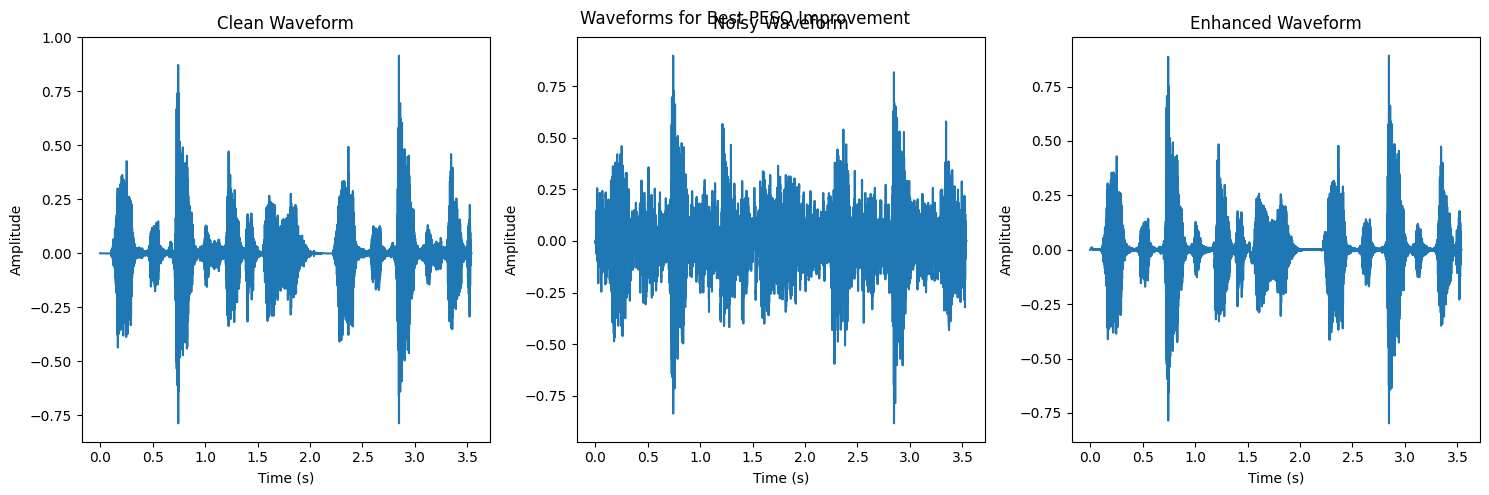

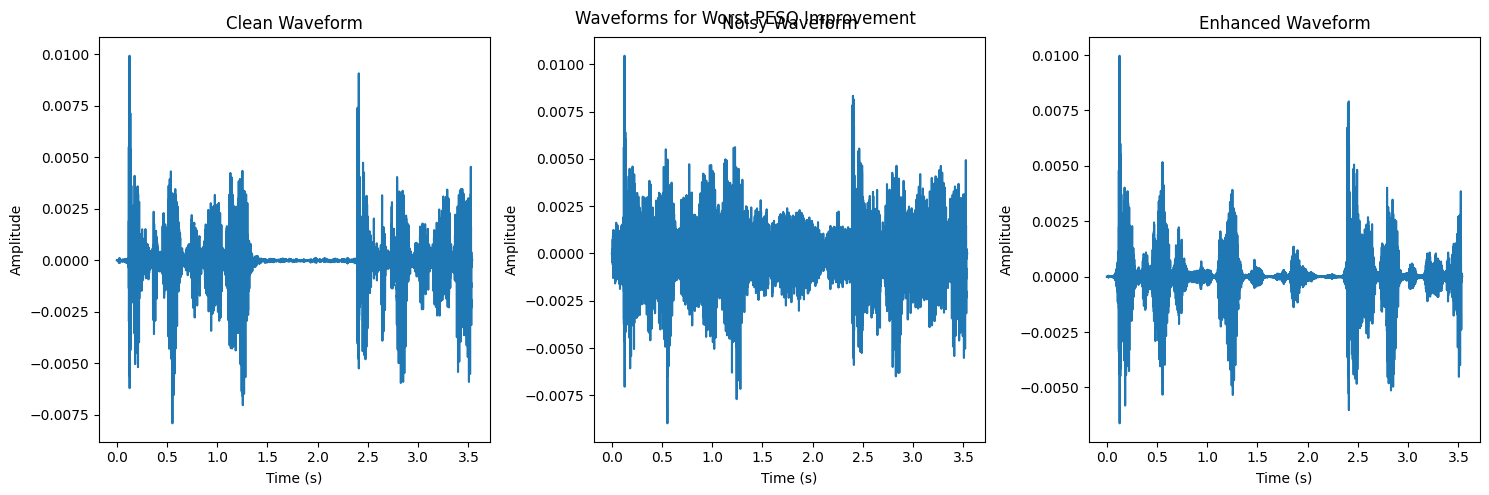

In [34]:
# Add this code after you have the wav_clean, wav_corrupt, and wav_correct arrays

def plot_waveforms(clean_wav, noisy_wav, enhanced_wav, sr, title="Audio Waveforms"):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(np.arange(len(clean_wav)) / sr, clean_wav)
    plt.title('Clean Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(noisy_wav)) / sr, noisy_wav)
    plt.title('Noisy Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(enhanced_wav)) / sr, enhanced_wav)
    plt.title('Enhanced Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Example usage after evaluation loop for a specific sample (e.g., the one with best PESQ)
ind_best = np.where(pesq_diff == pesq_diff.max())[0][0]
plot_waveforms(wav_clean_array[ind_best], wav_corrupt_array[ind_best], wav_correct_array[ind_best], sr, title="Waveforms for Best PESQ Improvement")

ind_worst = np.where(pesq_diff == pesq_diff.min())[0][0]
plot_waveforms(wav_clean_array[ind_worst], wav_corrupt_array[ind_worst], wav_correct_array[ind_worst], sr, title="Waveforms for Worst PESQ Improvement")

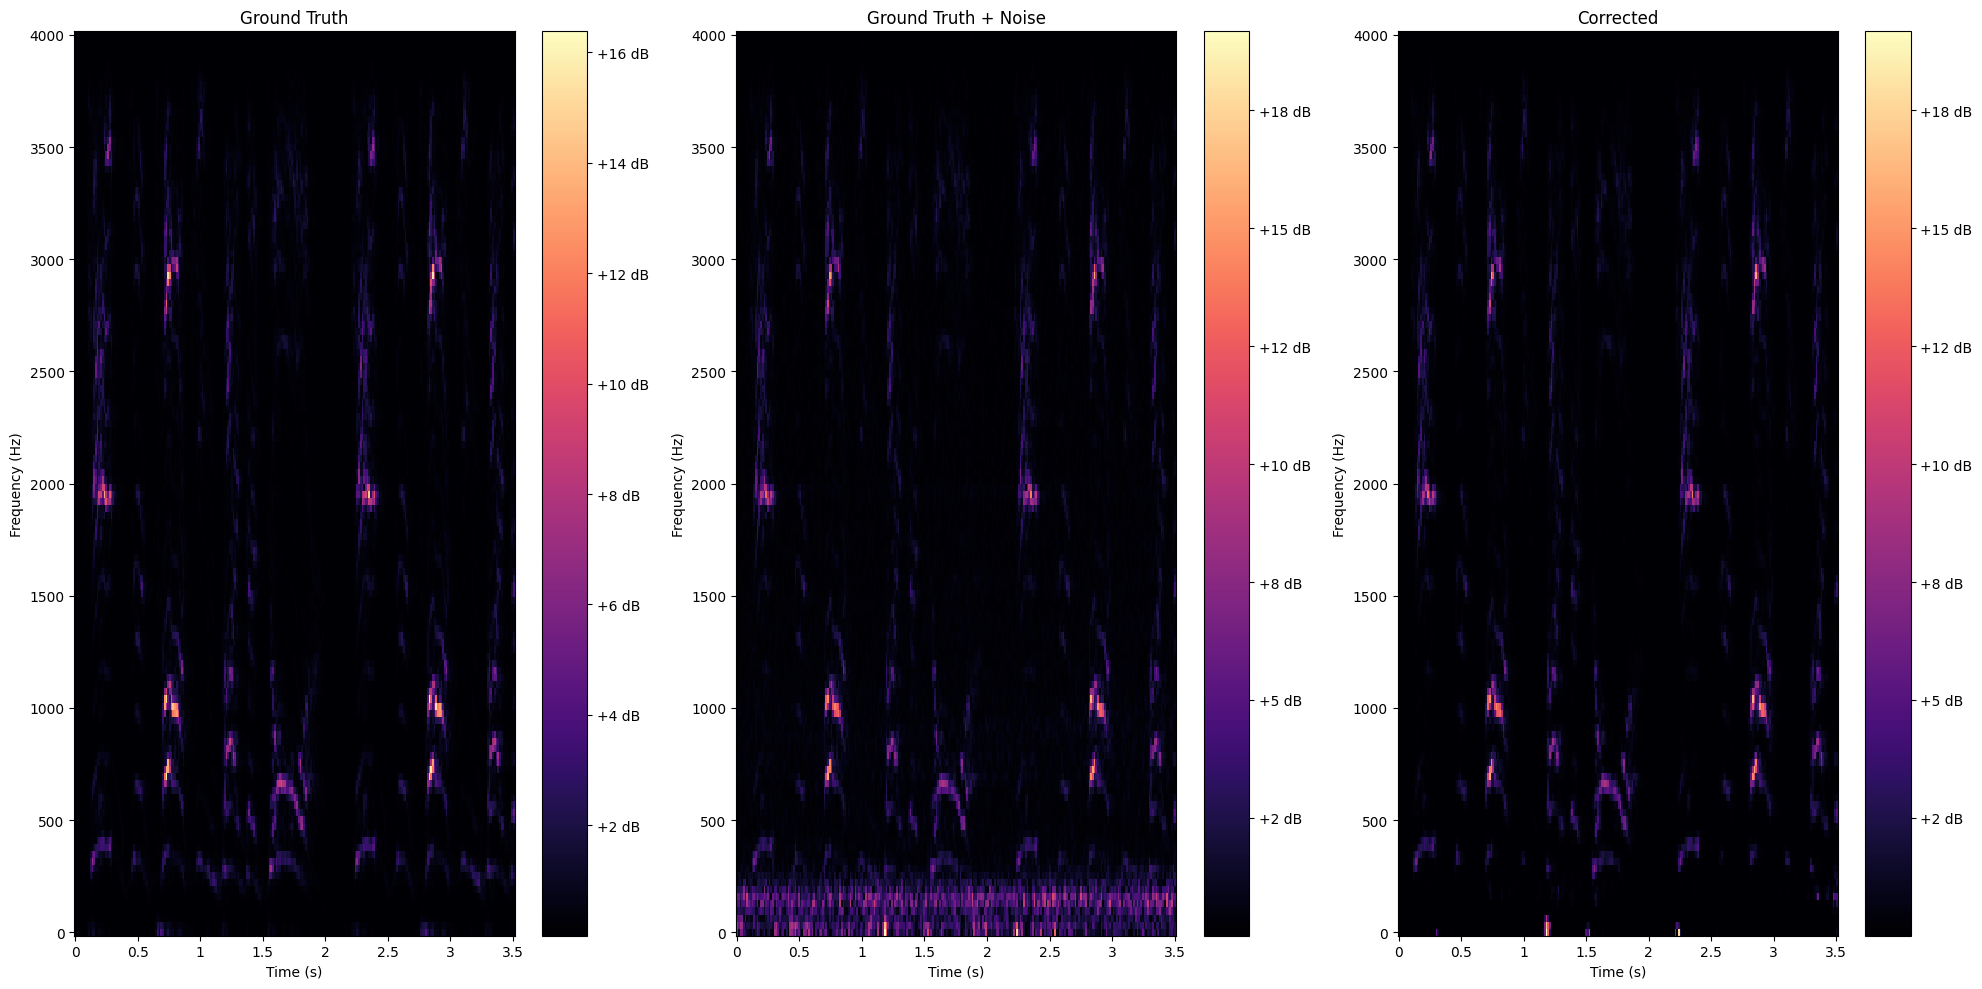

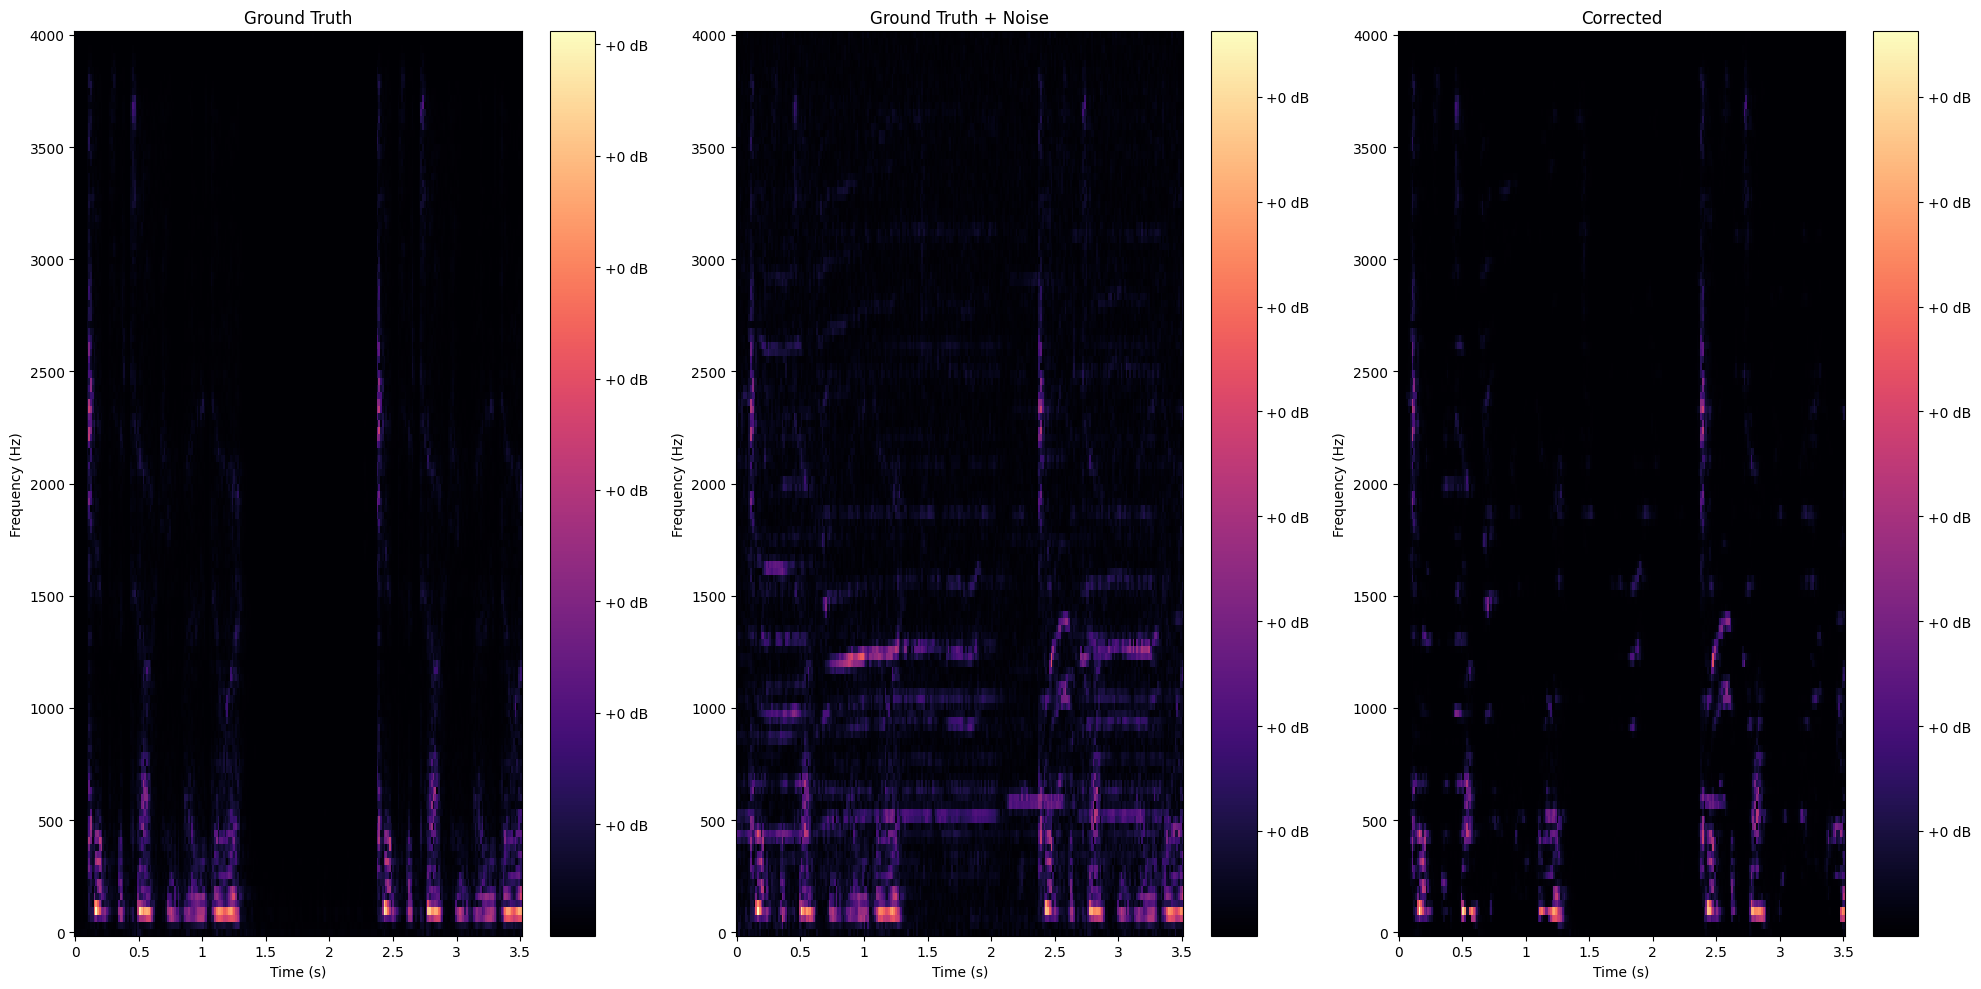

0

In [35]:
# Spectrogram visualization for best PESQ improvement
ind = np.where(pesq_diff == pesq_diff.max())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Calculate hop length in seconds
hop_length_sec = frame_step / sr

# Plot Clean Spectrogram
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
# Transpose the spectrogram data so time is on the x-axis and frequency on the y-axis
# Capture the mappable object returned by specshow
mappable_clean = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object to colorbar
plt.colorbar(mappable_clean, format='%+2.0f dB', ax=axes[0]) # Optional: add colorbar with dB format
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')


# Plot Corrupted Spectrogram
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram
# Capture the mappable object returned by specshow
mappable_corrupt = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object to colorbar
plt.colorbar(mappable_corrupt, format='%+2.0f dB', ax=axes[1]) # Optional: add colorbar with dB format
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram
plt.subplot(1, 3, 3)
plt.title('Corrected')
# Transpose and plot corrected spectrogram
# Capture the mappable object returned by specshow
mappable_correct = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object to colorbar
plt.colorbar(mappable_correct, format='%+2.0f dB', ax=axes[2]) # Optional: add colorbar with dB format
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')

# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/best_spec.png', bbox_inches='tight')
plt.show() # Display the plot

# Spectrogram visualization for worst PESQ improvement
ind = np.where(pesq_diff == pesq_diff.min())[0][0]
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))

# Plot Clean Spectrogram (Worst)
plt.subplot(1, 3, 1)
plt.title('Ground Truth')
# Transpose and plot clean spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_clean_worst = librosa.display.specshow(spec_clean_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[0])
# Pass the mappable object to colorbar
plt.colorbar(mappable_clean_worst, format='%+2.0f dB', ax=axes[0]) # Optional: add colorbar with dB format
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (Hz)')

# Plot Corrupted Spectrogram (Worst)
plt.subplot(1, 3, 2)
plt.title('Ground Truth + Noise')
# Transpose and plot corrupted spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_corrupt_worst = librosa.display.specshow(spec_corrupt_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[1])
# Pass the mappable object to colorbar
plt.colorbar(mappable_corrupt_worst, format='%+2.0f dB', ax=axes[1]) # Optional: add colorbar with dB format
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')

# Plot Corrected Spectrogram (Worst)
plt.subplot(1, 3, 3)
plt.title('Corrected')
# Transpose and plot corrected spectrogram for worst case
# Capture the mappable object returned by specshow
mappable_correct_worst = librosa.display.specshow(spec_correct_array[ind].T, sr=sr, hop_length=frame_step, x_axis='time', y_axis='hz', ax=axes[2])
# Pass the mappable object to colorbar
plt.colorbar(mappable_correct_worst, format='%+2.0f dB', ax=axes[2]) # Optional: add colorbar with dB format
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')


# Adjust layout and save
plt.tight_layout()
fig.savefig(results_dir + '/worst_spec.png', bbox_inches='tight')
plt.show() # Display the plot


# Archiving results (keep this as is)
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

Evaluating for SNR: -5 dB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

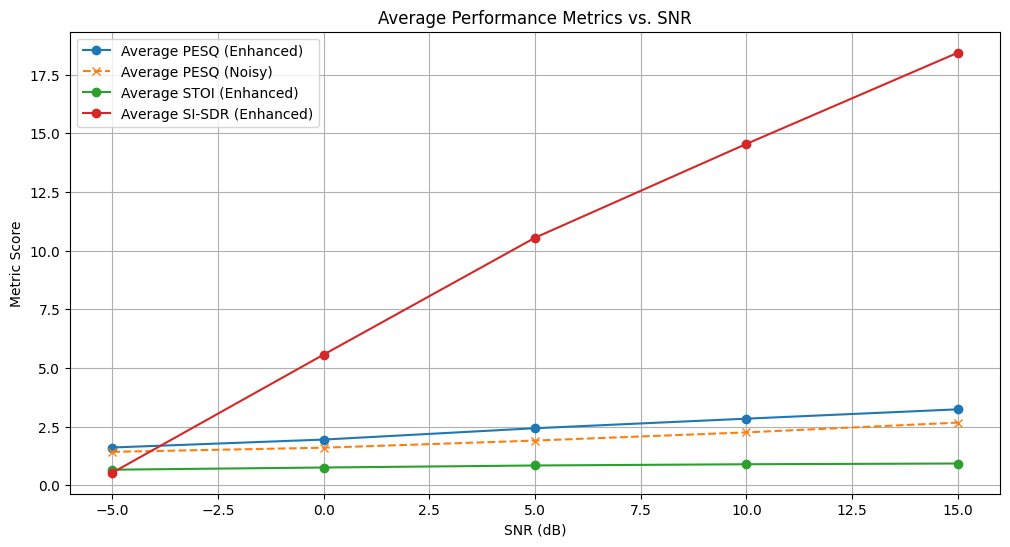

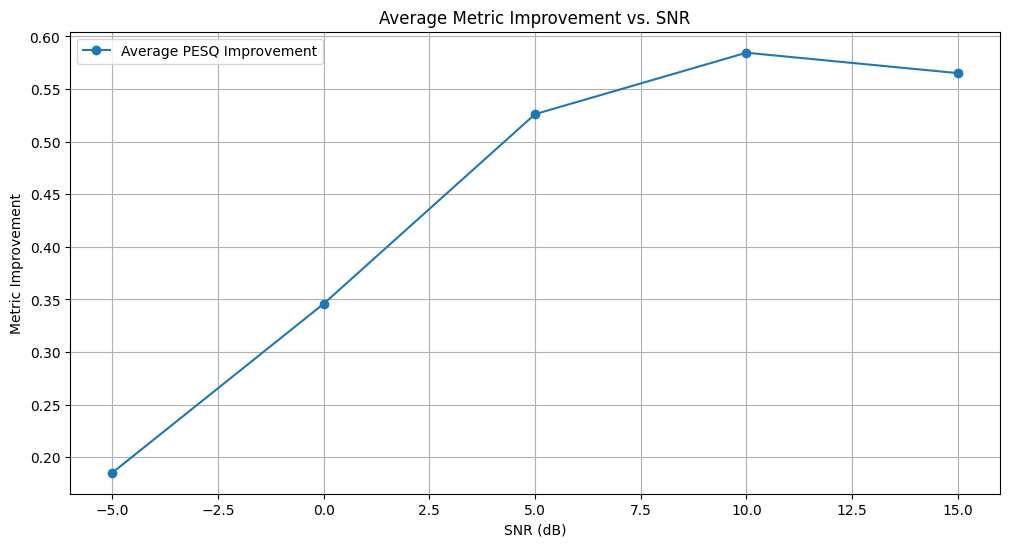


Example for SNR: -5 dB
Example audio files for SNR -5 dB saved to evaluation_results/audio_examples


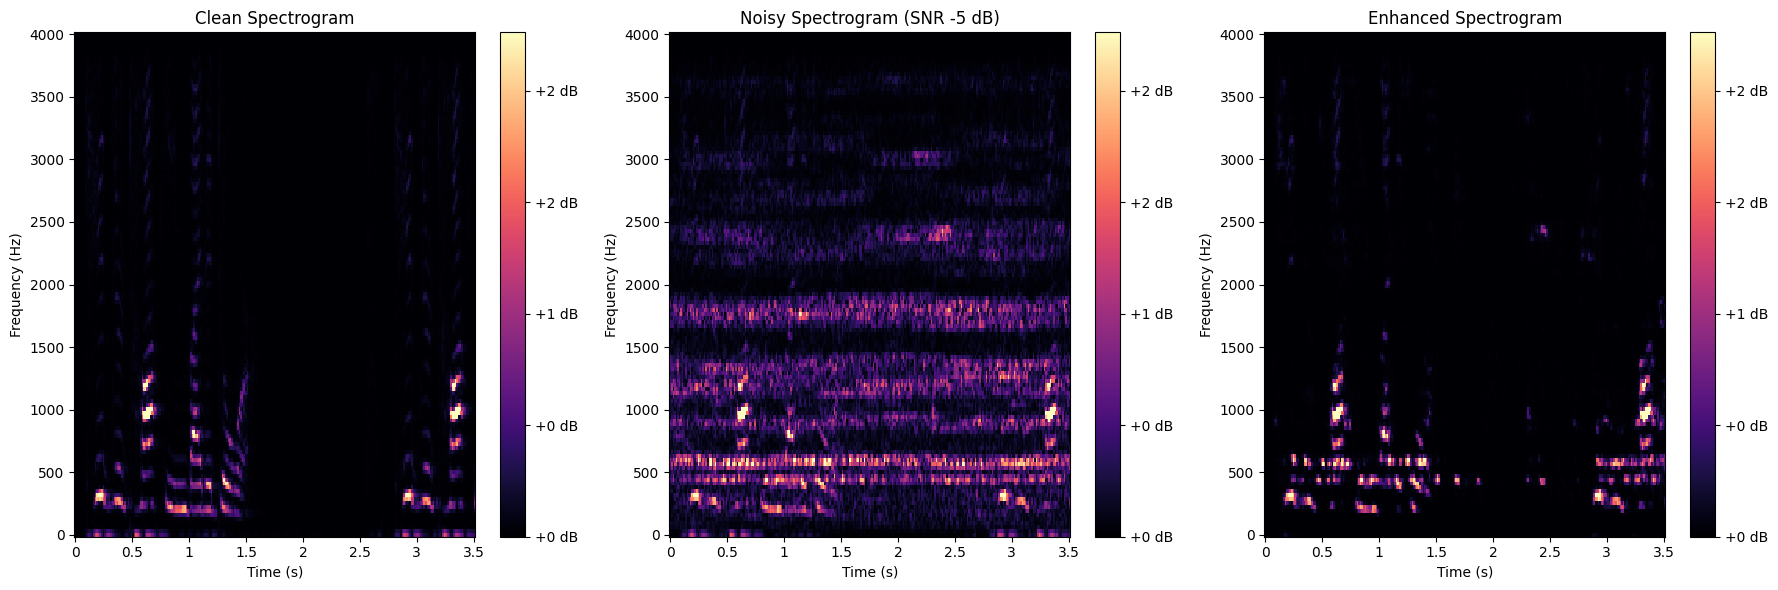


Example for SNR: 0 dB
Example audio files for SNR 0 dB saved to evaluation_results/audio_examples


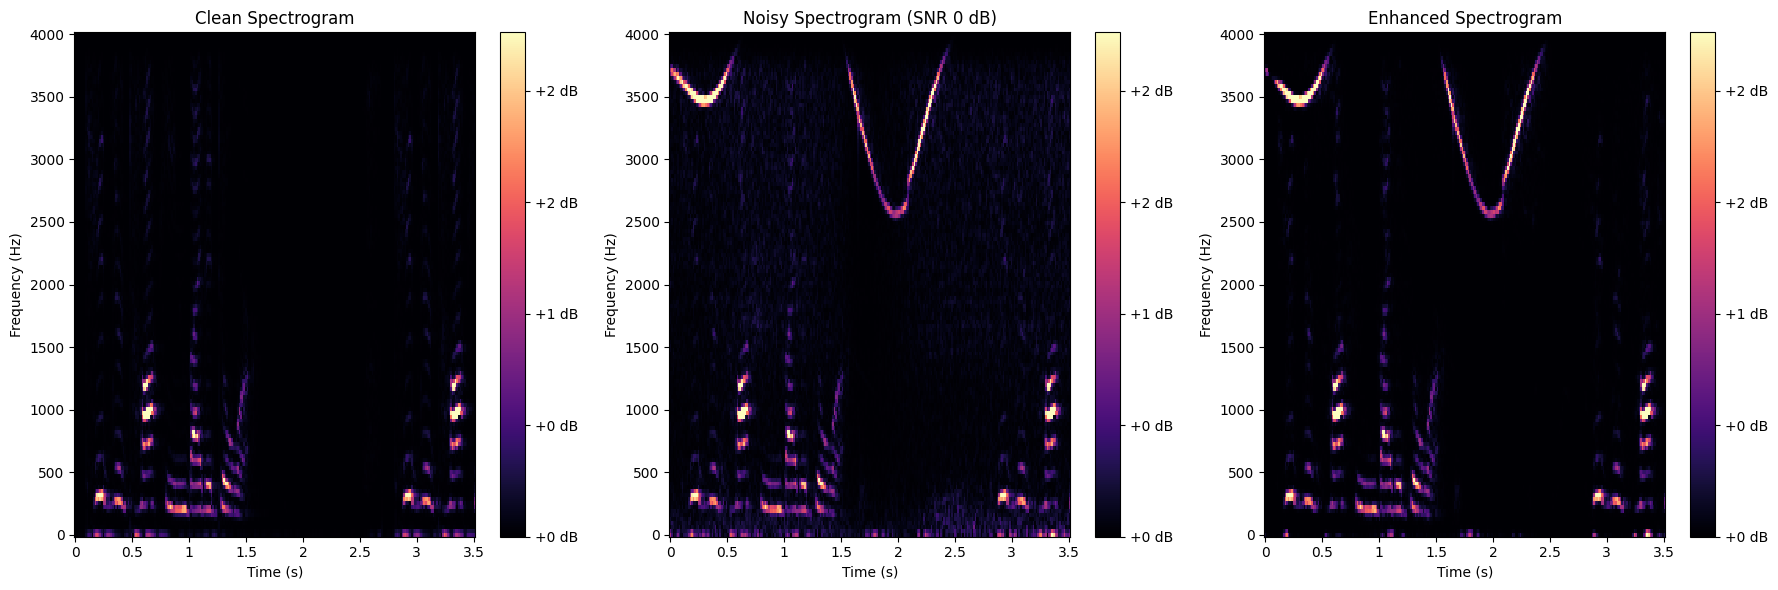


Example for SNR: 5 dB
Example audio files for SNR 5 dB saved to evaluation_results/audio_examples


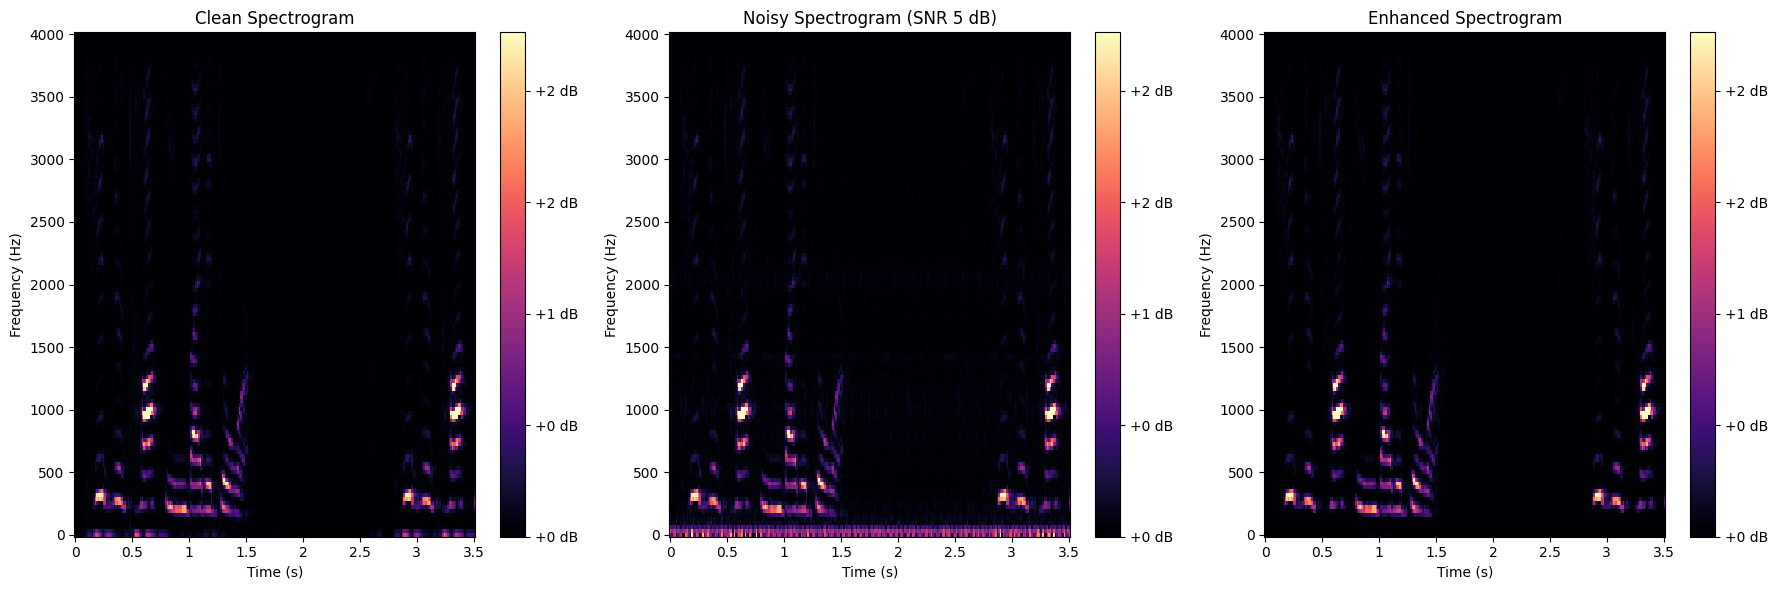


Example for SNR: 10 dB
Example audio files for SNR 10 dB saved to evaluation_results/audio_examples


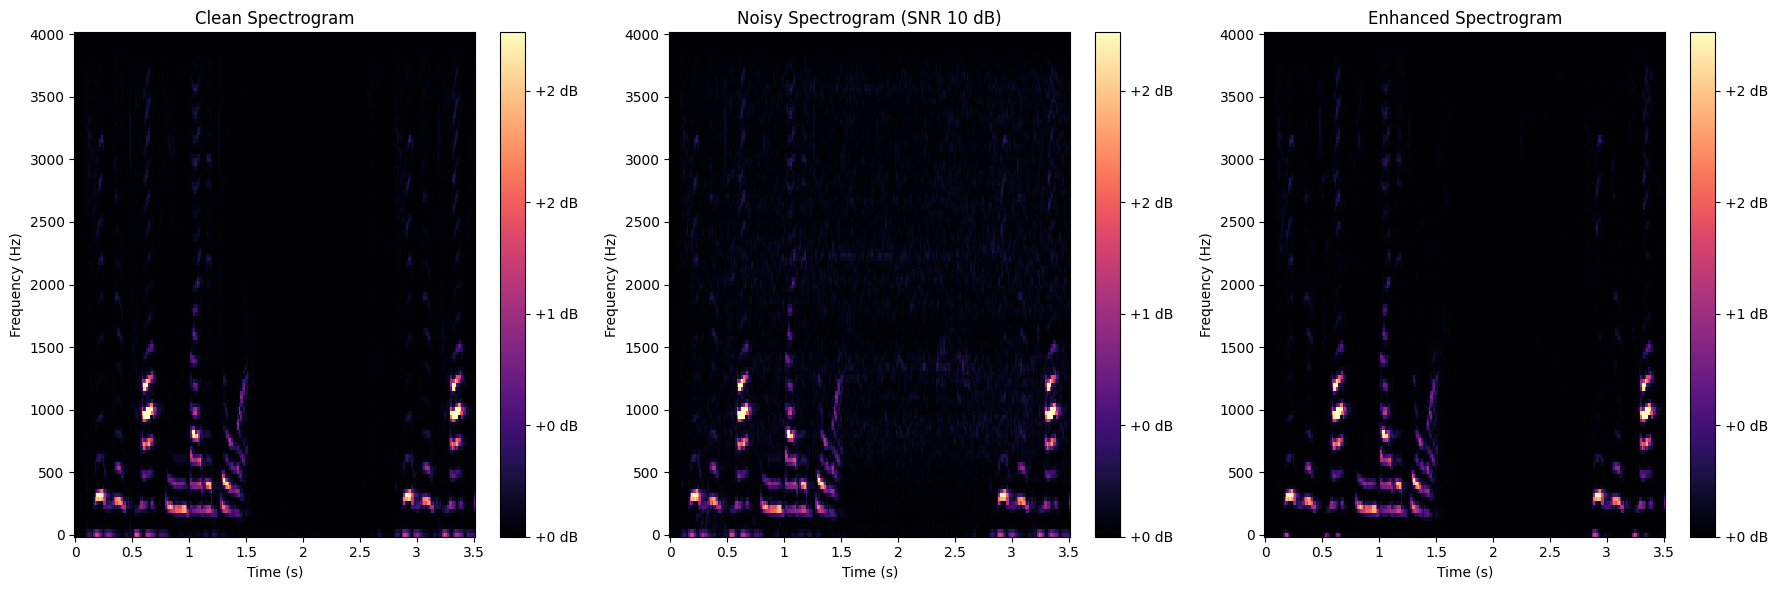


Example for SNR: 15 dB
Example audio files for SNR 15 dB saved to evaluation_results/audio_examples


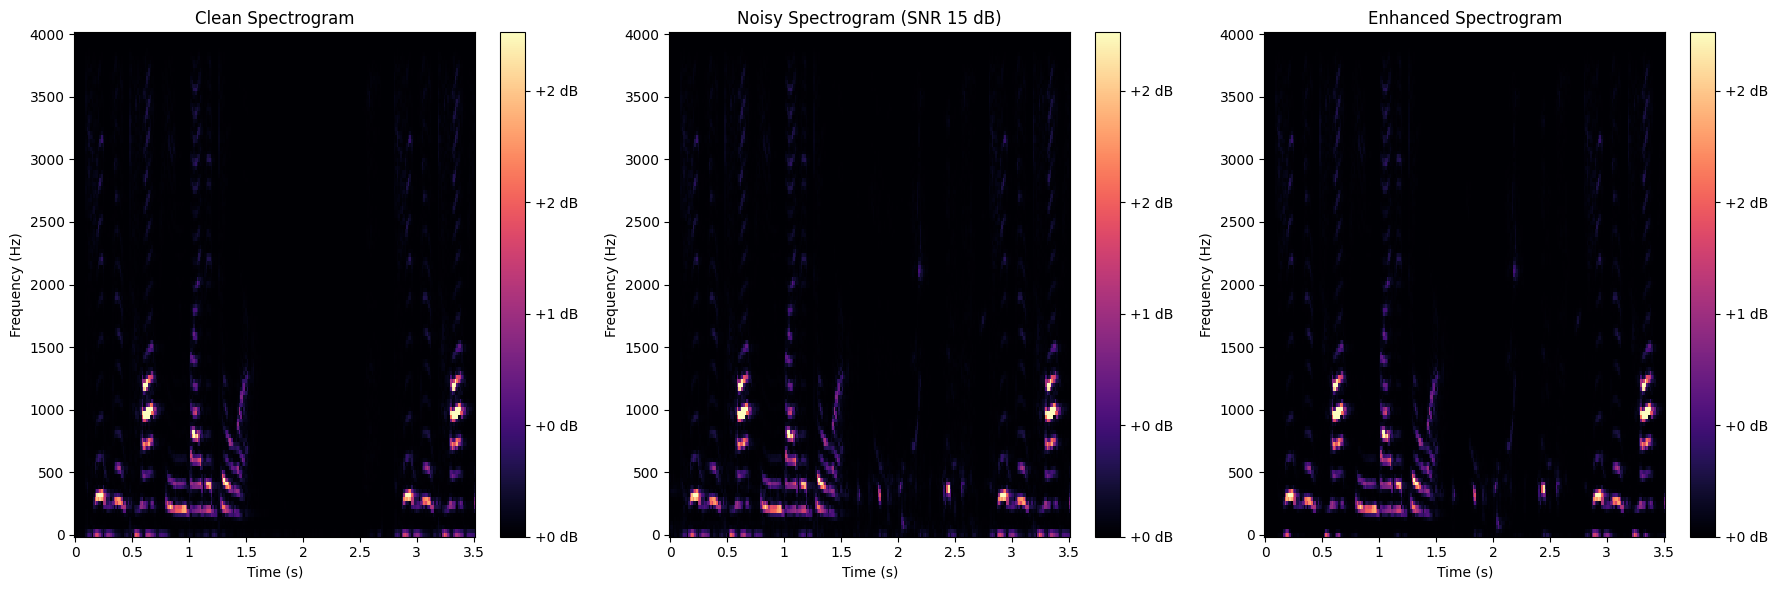

In [36]:
# Add these imports at the beginning of the file if not already present
import tensorflow as tf
import numpy as np
import librosa
from pystoi import stoi
from pesq import pesq
import soundfile as sf
import os
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for saving results to CSV

# Assuming your existing functions like load_wav, preprocess_tf,
# convert_to_spectrogram, spectrogram_abs, add_white_noise_with_snr,
# add_urban_noise_with_snr, configure_dataset_with_snr are defined.
# Also assuming your model is defined and loaded.

# Function to calculate SI-SDR
def calculate_si_sdr(clean, estimate):
    """Calculates Scale-Invariant Source-to-Distortion Ratio (SI-SDR)."""
    # Ensure inputs are numpy arrays
    clean = np.array(clean)
    estimate = np.array(estimate)

    # Ensure same length (assuming padding/trimming is done elsewhere)
    min_len = min(len(clean), len(estimate))
    clean = clean[:min_len]
    estimate = estimate[:min_len]

    # Calculate projection of estimate onto clean
    s_target = np.sum(estimate * clean) * clean / np.sum(clean ** 2) if np.sum(clean ** 2) != 0 else clean * 0

    # Calculate error
    e_noise = estimate - s_target

    # Calculate SI-SDR
    # Handle potential division by zero by adding a small epsilon to the denominator
    epsilon = 1e-10
    # Use tf.reduce_sum for compatibility if inputs were tensors before conversion
    si_sdr = 10 * np.log10(np.sum(s_target ** 2) / (np.sum(e_noise ** 2) + epsilon))

    return si_sdr


@tf.function
def add_white_noise_with_snr(data, snr_db, sr=8000):
    """Adds white noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(data ** 2)

    if tf.equal(signal_power, 0.0):
        return data, data # Avoid division by zero if signal is silent

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise
    noise = tf.random.normal(shape=tf.shape(data), stddev=tf.sqrt(tf.cast(noise_power, tf.float32)))

    # Add noise to the signal
    noisy_data = data + noise

    return noisy_data, data

@tf.function
def add_urban_noise_with_snr(corr_data, data, snr_db, sr=sr):
    """Adds urban noise to a signal at a specified SNR."""
    # Calculate signal power using TensorFlow operations
    signal_power = tf.reduce_mean(corr_data ** 2)

    if tf.equal(signal_power, 0.0):
        return corr_data, data # Avoid division by zero

    # Calculate noise power based on desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Select a random urban noise file
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)

    # Trim or pad noise file to match the length of the data
    noisefile = noisefile[:tf.shape(corr_data)[0]]
    zero_padding = tf.zeros([tf.shape(corr_data)[0]] - tf.shape(noisefile), dtype=tf.float32)
    noisefile = tf.concat([noisefile, zero_padding], 0)

    # Scale the noise file to the desired noise power using TensorFlow operations
    noisefile_power = tf.reduce_mean(noisefile ** 2)
    # Handle potential division by zero within the TensorFlow graph
    noisefile = tf.cond(
        tf.math.not_equal(noisefile_power, 0.0),
        lambda: noisefile * tf.sqrt(tf.cast(noise_power / noisefile_power, tf.float32)),
        lambda: noisefile # If noise power is zero, return the original noisefile
    )

    # Add noise to the signal
    mixed = corr_data + noisefile

    return mixed, data


# Modify configure_dataset to include SNR control and return complex spectrograms for evaluation
def configure_dataset_with_snr_eval(files, snr_db):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)

    # Add noise with specified SNR - returns noisy_wav, clean_wav
    dataset = dataset.map(lambda x: add_urban_noise_with_snr(x, x, snr_db), num_parallel_calls=tf.data.AUTOTUNE)

    # Convert to complex spectrograms - returns corr_spec (complex), clean_spec (complex)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

    # We don't apply spectrogram_abs, augment, or expand_dims for evaluation here.
    # The model expects magnitude spectrogram with channel dimension, so we'll handle that in the loop.

    # return clean_spec (complex), corr_spec (complex)
    return dataset.map(lambda corr_spec, clean_spec: (clean_spec, corr_spec))


# Define the SNR levels you want to evaluate
snr_levels = [-5, 0, 5, 10, 15]

# Initialize dictionaries to store results and visualization data
pesq_results = {}
stoi_results = {}
si_sdr_results = {}
pesq_noisy_results = {} # To store PESQ of noisy signal

# Dictionaries to store example data for visualization and audio saving
example_data = {
    'clean_wav': {},
    'noisy_wav': {},
    'enhanced_wav': {},
    'clean_spec': {},
    'noisy_spec': {},
    'enhanced_spec': {}
}

# Create results directory if it doesn't exist
results_dir = 'evaluation_results'
os.makedirs(results_dir, exist_ok=True)
audio_results_dir = os.path.join(results_dir, 'audio_examples')
os.makedirs(audio_results_dir, exist_ok=True)

for snr_db in snr_levels:
    print(f"Evaluating for SNR: {snr_db} dB")
    # Create a test dataset for the current SNR level
    # configure_dataset_with_snr_eval returns clean_spec (complex), corr_spec (complex)
    test_dataset_snr = configure_dataset_with_snr_eval(val_files, snr_db)

    pesq_scores = []
    stoi_scores = []
    si_sdr_scores = []
    pesq_noisy_scores = [] # List to store PESQ of noisy signal

    # Iterate through the dataset. Use batch(1) to process one sample at a time
    # The dataset now returns (clean_spec (complex), corr_spec (complex))
    for batch_idx, (clean_spec_batch, corr_spec_batch) in enumerate(test_dataset_snr.batch(1).as_numpy_iterator()):
        # Remove batch dimension
        clean_spec = clean_spec_batch[0]
        corr_spec = corr_spec_batch[0]

        # Get the original phase from the noisy spectrogram
        corr_phase = np.angle(corr_spec)

        # Get magnitude for model prediction and add channel dimension
        corr_amp = np.abs(corr_spec)
        # Add batch dimension and channel dimension for prediction
        # Model expects input shape (batch_size, frames, fft_bins, channels)
        input_spectrogram = np.expand_dims(np.expand_dims(corr_amp, 0), -1)
        corrected_amp = model.predict(input_spectrogram)

        # Remove batch dimension and channel dimension after prediction
        # The output from model.predict has shape (batch_size, frames, fft_bins, 1)
        corrected_amp = corrected_amp[0, :, :, 0]

        # Combine predicted magnitude with original phase to get complex spectrogram
        corrected_spec = corrected_amp * np.exp(1j * corr_phase)

        # Convert spectrograms back to audio
        try:
            # Ensure shapes are correct for inverse_stft: (..., frames, fft_bins)
            corr_wav = tf.signal.inverse_stft(corr_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            clean_wav = tf.signal.inverse_stft(clean_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here
            corrected_wav = tf.signal.inverse_stft(corrected_spec, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step).numpy() # Don't squeeze here

            # Ensure audio signals have the same length before calculating metrics
            min_len = min(clean_wav.shape[-1], corr_wav.shape[-1], corrected_wav.shape[-1])
            clean_wav = clean_wav[..., :min_len] # Trim along the time dimension
            corr_wav = corr_wav[..., :min_len]
            corrected_wav = corrected_wav[..., :min_len]

            # Squeeze the channel dimension if present after inverse_stft
            clean_wav = clean_wav.squeeze()
            corr_wav = corr_wav.squeeze()
            corrected_wav = corrected_wav.squeeze()


            # Calculate metrics
            # PESQ and STOI require 1D numpy arrays
            try:
                # PESQ of noisy signal
                pesq_noisy_score = pesq(sr, clean_wav, corr_wav, 'nb')
                pesq_noisy_scores.append(pesq_noisy_score)

                # PESQ of enhanced signal
                pesq_score = pesq(sr, clean_wav, corrected_wav, 'nb')
                pesq_scores.append(pesq_score)
            except Exception as e:
                print(f"Error calculating PESQ for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                stoi_score = stoi(clean_wav, corrected_wav, sr, extended=False)
                stoi_scores.append(stoi_score)
            except Exception as e:
                print(f"Error calculating STOI for SNR {snr_db}, sample {batch_idx}: {e}")

            try:
                si_sdr_score = calculate_si_sdr(clean_wav, corrected_wav)
                si_sdr_scores.append(si_sdr_score)
            except Exception as e:
                 print(f"Error calculating SI-SDR for SNR {snr_db}, sample {batch_idx}: {e}")
                 si_sdr_scores.append(np.nan) # Append NaN or a placeholder

            # Store example data for visualization and audio saving (e.g., for the first sample of each SNR)
            if batch_idx == 0: # Store only the first sample of each SNR level
                 example_data['clean_wav'][snr_db] = clean_wav
                 example_data['noisy_wav'][snr_db] = corr_wav
                 example_data['enhanced_wav'][snr_db] = corrected_wav
                 example_data['clean_spec'][snr_db] = np.abs(clean_spec)
                 example_data['noisy_spec'][snr_db] = np.abs(corr_spec)
                 example_data['enhanced_spec'][snr_db] = corrected_amp

        except Exception as e:
            print(f"Error processing sample for SNR {snr_db}, batch {batch_idx}: {e}")
            continue # Skip to the next batch if there's an error converting back to audio


    # Store the average scores for the current SNR level
    pesq_results[snr_db] = np.mean(pesq_scores) if pesq_scores else np.nan
    stoi_results[snr_db] = np.mean(stoi_scores) if stoi_scores else np.nan
    si_sdr_results[snr_db] = np.nanmean(si_sdr_scores) if si_sdr_scores else np.nan # Use nanmean to handle NaNs
    pesq_noisy_results[snr_db] = np.mean(pesq_noisy_scores) if pesq_noisy_scores else np.nan # Store average noisy PESQ

# --- Save Metrics to CSV ---
metrics_df = pd.DataFrame({
    'SNR_dB': snr_levels,
    'Average_PESQ_Noisy': [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels],
    'Average_PESQ_Enhanced': [pesq_results.get(snr, np.nan) for snr in snr_levels],
    'Average_STOI_Enhanced': [stoi_results.get(snr, np.nan) for snr in snr_levels],
    'Average_SI_SDR_Enhanced': [si_sdr_results.get(snr, np.nan) for snr in snr_levels]
})
metrics_df.to_csv(os.path.join(results_dir, 'average_metrics_by_snr.csv'), index=False)
print(f"\nAverage metrics saved to {os.path.join(results_dir, 'average_metrics_by_snr.csv')}")

# Print the results
print("\nPerformance Metrics Across Different SNR Levels:")
print("SNR (dB) | Avg PESQ (Noisy) | Avg PESQ (Enhanced) | Avg STOI (Enhanced) | Avg SI-SDR (Enhanced)")
print("------------------------------------------------------------------------")
for snr_db in snr_levels:
    print(f"{snr_db:<8} | {pesq_noisy_results.get(snr_db, np.nan):<16.2f} | {pesq_results.get(snr_db, np.nan):<19.2f} | {stoi_results.get(snr_db, np.nan):<19.2f} | {si_sdr_results.get(snr_db, np.nan):<20.2f}")


# --- Visualization ---

# Plot average metrics vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_levels, [pesq_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average PESQ (Enhanced)')
plt.plot(snr_levels, [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels], marker='x', linestyle='--', label='Average PESQ (Noisy)') # Add noisy PESQ
plt.plot(snr_levels, [stoi_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average STOI (Enhanced)')
plt.plot(snr_levels, [si_sdr_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average SI-SDR (Enhanced)')
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Score')
plt.title('Average Performance Metrics vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metrics_vs_snr.png'), bbox_inches='tight')
plt.show()

# Plot average metric improvement vs. SNR
plt.figure(figsize=(12, 6))
pesq_improvement = [pesq_results.get(snr, np.nan) - pesq_noisy_results.get(snr, np.nan) for snr in snr_levels]
plt.plot(snr_levels, pesq_improvement, marker='o', label='Average PESQ Improvement')
# You could potentially calculate and plot STOI/SI-SDR improvement if you calculated noisy STOI/SI-SDR
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Improvement')
plt.title('Average Metric Improvement vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metric_improvement_vs_snr.png'), bbox_inches='tight')
plt.show()


# Visualize example spectrograms per SNR level and save audio
for snr_db in snr_levels:
    if snr_db in example_data['clean_wav']: # Check if we stored an example for this SNR
        print(f"\nExample for SNR: {snr_db} dB")
        clean_wav_ex = example_data['clean_wav'][snr_db]
        noisy_wav_ex = example_data['noisy_wav'][snr_db]
        enhanced_wav_ex = example_data['enhanced_wav'][snr_db]
        clean_spec_ex = example_data['clean_spec'][snr_db]
        noisy_spec_ex = example_data['noisy_spec'][snr_db]
        enhanced_spec_ex = example_data['enhanced_spec'][snr_db]


        # Save example audio files
        sf.write(os.path.join(audio_results_dir, f'clean_snr_{snr_db}dB.wav'), clean_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'noisy_snr_{snr_db}dB.wav'), noisy_wav_ex, sr)
        sf.write(os.path.join(audio_results_dir, f'enhanced_snr_{snr_db}dB.wav'), enhanced_wav_ex, sr)
        print(f"Example audio files for SNR {snr_db} dB saved to {audio_results_dir}")

        # Plot spectrograms
        fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
        # Set a common color scale based on the max value of the clean spectrogram
        vmax = np.max(clean_spec_ex) / 3
        vmin = 0
        # Define hop length for librosa plotting
        hop_length = frame_step # Use the same frame_step as in STFT

        ax = axes[0]
        # Use librosa.display.specshow for better spectrogram visualization
        img = librosa.display.specshow(clean_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title('Clean Spectrogram')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        ax = axes[1]
        # Use librosa.display.specshow for noisy spectrogram
        img = librosa.display.specshow(noisy_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title(f'Noisy Spectrogram (SNR {snr_db} dB)')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        ax = axes[2]
        # Use librosa.display.specshow for enhanced spectrogram
        img = librosa.display.specshow(enhanced_spec_ex.T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', ax=ax, vmax=vmax, vmin=vmin)
        ax.set_title('Enhanced Spectrogram')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        # Add colorbar specific to this axes
        fig.colorbar(img, ax=ax, format='%+2.0f dB')


        # fig.colorbar(img, ax=axes.ravel().tolist()) # Remove this line
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'spectrograms_snr_{snr_db}.png'), bbox_inches='tight')
        plt.show()

# You might want to add archiving the 'evaluation_results' directory as well
# os.system(f'tar -cvzf evaluation_results.tar.gz {results_dir}')

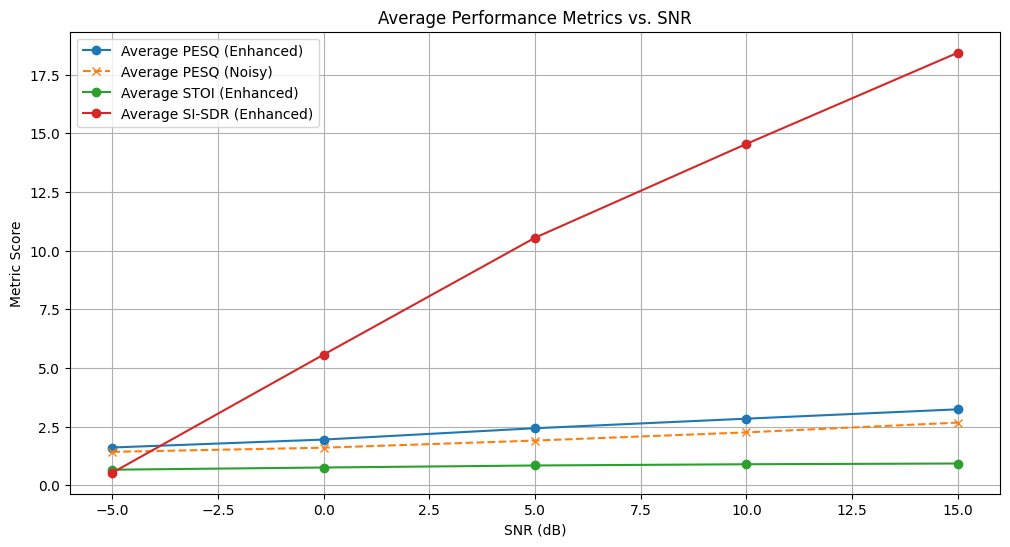

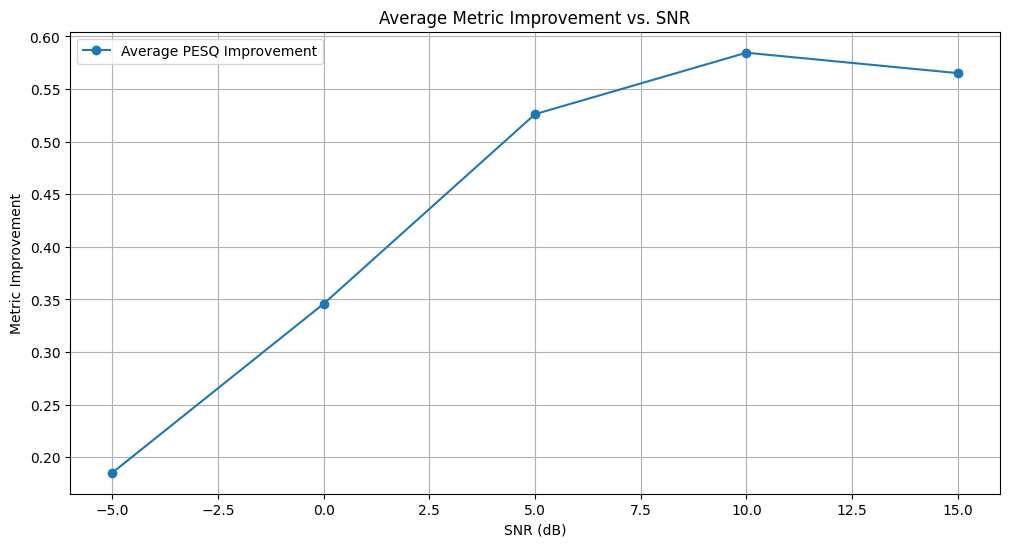

In [37]:
# Plot average metrics vs. SNR
plt.figure(figsize=(12, 6))
plt.plot(snr_levels, [pesq_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average PESQ (Enhanced)')
plt.plot(snr_levels, [pesq_noisy_results.get(snr, np.nan) for snr in snr_levels], marker='x', linestyle='--', label='Average PESQ (Noisy)') # Add noisy PESQ
plt.plot(snr_levels, [stoi_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average STOI (Enhanced)')
plt.plot(snr_levels, [si_sdr_results.get(snr, np.nan) for snr in snr_levels], marker='o', label='Average SI-SDR (Enhanced)')
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Score')
plt.title('Average Performance Metrics vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metrics_vs_snr.png'), bbox_inches='tight')
plt.show()

# Plot average metric improvement vs. SNR
plt.figure(figsize=(12, 6))
pesq_improvement = [pesq_results.get(snr, np.nan) - pesq_noisy_results.get(snr, np.nan) for snr in snr_levels]
plt.plot(snr_levels, pesq_improvement, marker='o', label='Average PESQ Improvement')
# You could potentially calculate and plot STOI/SI-SDR improvement if you calculated noisy STOI/SI-SDR
plt.xlabel('SNR (dB)')
plt.ylabel('Metric Improvement')
plt.title('Average Metric Improvement vs. SNR')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'average_metric_improvement_vs_snr.png'), bbox_inches='tight')
plt.show()